<font size="+3.8">Scanpy single-cell pre-processing</font>  
<font size="+1.5"></font>  

Aim: Preprocess mouse brain single-cell data from Yang 2022 Nature  
Publication: https://www.nature.com/articles/s41586-021-04369-3

In [1]:
from datetime import date
date.today().strftime('%d/%m/%Y')

'22/01/2024'

In [2]:
import os
os.getlogin()

'sfrerich'

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import random
import seaborn as sns
import platform
from matplotlib.pyplot import rc_context

In [4]:
os.environ['CONDA_DEFAULT_ENV'] # conda env

'scanpy'

In [5]:
platform.platform()

'Windows-10-10.0.14393-SP0'

In [6]:
sc.settings.verbosity = 3

In [7]:
main_dir='/run/user/1000/gvfs/smb-share:server=138.245.4.35,share=bd-dichgans/SF' # Linux

In [8]:
main_dir='\\\isdsynnas.srv.med.uni-muenchen.de\BD-Dichgans\SF' # Win

# Load data

## Annotated 
Downloaded from: https://cells.ucsc.edu/?ds=brain-vasc-atlas

In [9]:
ad = sc.read_mtx(main_dir+"\\P06_vasc_scRNAseq\Yang2021\\ucsc_cellbrowser_data\\matrix.mtx.gz").transpose()

In [10]:
ad

AnnData object with n_obs × n_vars = 143793 × 23537

In [11]:
# Add var

In [12]:
var = pd.read_csv(main_dir+"\\P06_vasc_scRNAseq\Yang2021\\ucsc_cellbrowser_data\\features.tsv.gz", sep="\t", header=None)
all(var[0] == var[1])

True

In [13]:
var.index = var[0]
var.index.name = None

In [14]:
ad.var = var[[0]]
ad.var

0
AL627309.1  AL627309.1
AL669831.5  AL669831.5
LINC00115    LINC00115
AL645608.1  AL645608.1
SAMD11          SAMD11
...                ...
NCF4-AS1      NCF4-AS1
AL022316.1  AL022316.1
AL021392.1  AL021392.1
CU638689.4  CU638689.4
AP001136.1  AP001136.1

[23537 rows x 1 columns]

In [15]:
# Original cellnames

In [16]:
cellnames = pd.read_csv(main_dir+"\\P06_vasc_scRNAseq\Yang2021\\ucsc_cellbrowser_data\\barcodes.tsv.gz", sep="\t", header=None)
# used below to assert order

In [17]:
# Add metadata

In [18]:
meta = pd.read_csv(main_dir+"\\P06_vasc_scRNAseq\\Yang2021\\ucsc_cellbrowser_data\\meta.tsv", sep="\t")

In [19]:
ad.obs = meta
ad

AnnData object with n_obs × n_vars = 143793 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type'
    var: 0

In [20]:
ad.obs.columns

Index(['Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample',
       'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3',
       'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region',
       'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34',
       'APOE_Number', 'Cell_Type'],
      dtype='object')

In [21]:
ad.obs.head(2)

Cell orig.ident  nCount_RNA  nFeature_RNA    Treat Sample  \
0  AAACCCAAGAAGTGTT-1_1   HuVascAD        1450          1034  Control     C1   
1  AAACCCAAGGCAGCTA-1_1   HuVascAD        1059           767  Control     C1   

        Region  nCount_SCT  nFeature_SCT  integrated_snn_res.0.3  ...  Age  \
0  Hippocampus        1255          1034                       4  ...   58   
1  Hippocampus        1049           767                      17  ...   58   

  Batch   Sample_Region  Region_Number Seurat_n  Seurat_Clusters  APOE4  \
0     2  C1_Hippocampus              0        5                4    yes   
1     2  C1_Hippocampus              0       18               17    yes   

   APOE34 APOE_Number Cell_Type  
0      E4           1   Veinous  
1      E4           1    T cell  

[2 rows x 22 columns]

In [22]:
assert(all(ad.obs["Cell"] == cellnames[0]))

In [23]:
# add umap coords
umap = pd.read_csv(main_dir+"\\P06_vasc_scRNAseq\\Yang2021\\ucsc_cellbrowser_data\\UMAP.coords.tsv.gz", sep="\t", header=None)
ad.obsm['X_umap'] = umap[[1,2]].to_numpy()

In [24]:
# Exclude AD cases - keep healthy controls only

In [25]:
ad.obs["Sample"].unique()

array(['C1', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8', 'C9', 'AD1', 'AD2',
       'AD3', 'AD4', 'AD5', 'AD6', 'AD7', 'AD8', 'AD9'], dtype=object)

In [26]:
pd.value_counts(ad.obs["Sample"])

Sample
C1     14026
AD4    14006
AD5    12200
C7     11641
C8     10371
C9      9886
AD7     9484
AD9     9126
C5      8427
AD6     7485
AD1     7454
C2      6948
C4      6439
AD2     5320
AD3     5291
C3      4633
AD8     1056
Name: count, dtype: int64

In [27]:
controls = ['C1', 'C2', 'C3', 'C4', 'C5', 'C7', 'C8', 'C9']

In [28]:
ad = ad[ad.obs["Sample"].isin(controls)]

In [29]:
pd.value_counts(ad.obs["Cell_Type"])

Cell_Type
Pericyte        17561
Capillary       13357
Astrocyte        9943
Oligo            8528
Veinous          7139
SMC              4669
Arterial         4486
P. Fibro         1882
OPC              1509
Microglia/Mφ     1142
Neuron            933
Ependymal         885
T cell            187
M. Fibro          150
Name: count, dtype: int64

In [30]:
pd.value_counts(ad.obs["Region"])

Region
Hippocampus    48500
Cortex         23871
Name: count, dtype: int64

In [31]:
pd.value_counts(ad.obs["Sample_Region"])

Sample_Region
C5_Hippocampus    8427
C1_Cortex         7258
C2_Hippocampus    6948
C1_Hippocampus    6768
C4_Hippocampus    6439
C7_Cortex         6024
C7_Hippocampus    5617
C9_Cortex         5377
C8_Cortex         5212
C8_Hippocampus    5159
C3_Hippocampus    4633
C9_Hippocampus    4509
Name: count, dtype: int64

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\anndata\_core\anndata.py:1230: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key]

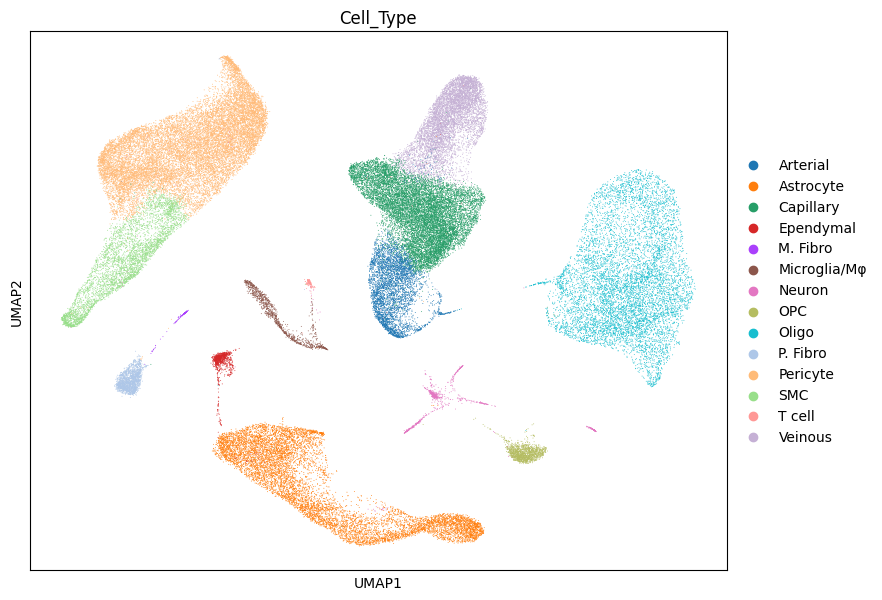

In [32]:
with rc_context({'figure.figsize': (9, 7)}):
    sc.pl.umap(ad, color=['Cell_Type'])

In [33]:
# Renaming
old_to_new = {'Arterial':'ECs_Arterial',
              'Astrocyte':'Astrocytes',
              'Capillary':'ECs_Capillary',
              'Ependymal':'Ependymal cells',
              'M. Fibro':'Fibroblasts',
              'Microglia/Mφ':'Microglia/Macrophages',
              'Neuron':'Neurons',
              'OPC':'OPCs',
              'P. Fibro':'Fibroblasts',
              'Pericyte':'Pericytes',
              'SMC':'SMCs',
              'T cell':'T cells',
              'Veinous':'ECs_Venous',
              'Oligo':'Oligos'}
ad.obs['clusters2'] = (ad.obs['Cell_Type'].map(old_to_new).astype('category'))

In [34]:
# Renaming
old_to_new = {'ECs_Arterial':'ECs',
              'Astrocytes':'Astrocytes',
              'ECs_Capillary':'ECs',
              'Ependymal cells':'Ependymal cells',
              'Fibroblasts':'Fibroblasts',
              'Microglia/Macrophages':'Microglia/Macrophages',
              'Neurons':'Neurons',
              'OPCs':'OPCs',
              'Fibroblasts':'Fibroblasts',
              'Pericytes':'Pericytes',
              'SMCs':'SMCs',
              'T cells':'T cells',
              'ECs_Venous':'ECs',
              'Oligos':'Oligos'}
ad.obs['clusters'] = (ad.obs['clusters2'].map(old_to_new).astype('category'))

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


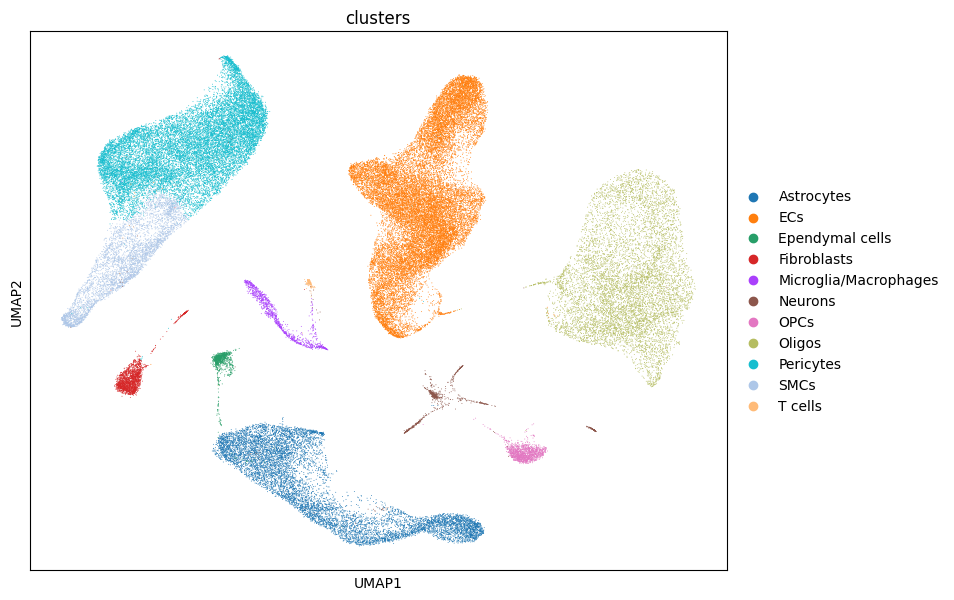

In [35]:
with rc_context({'figure.figsize': (9, 7)}):
    sc.pl.umap(ad, color=['clusters'])

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


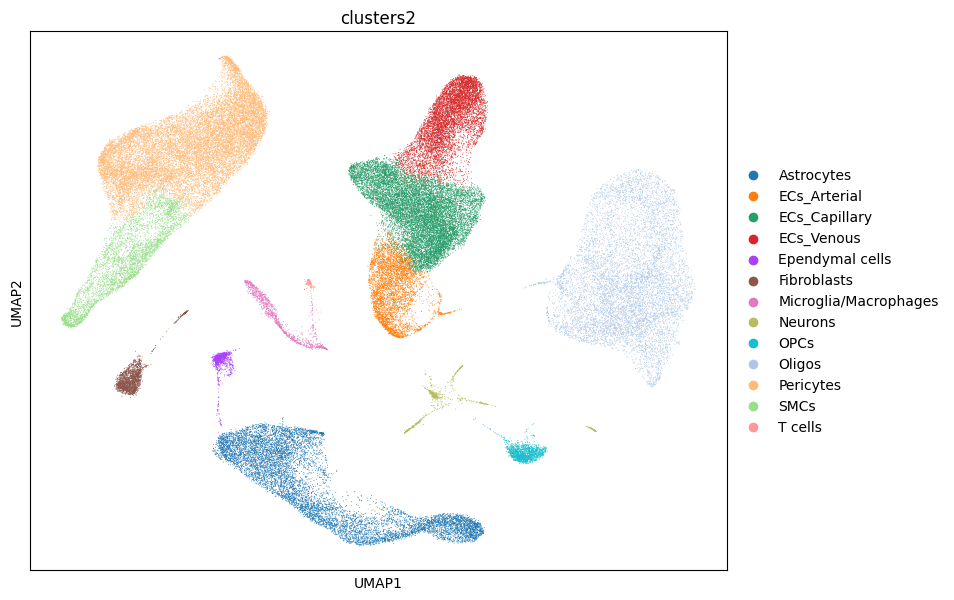

In [36]:
with rc_context({'figure.figsize': (9, 7)}):
    sc.pl.umap(ad, color=['clusters2'])

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_tools\scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


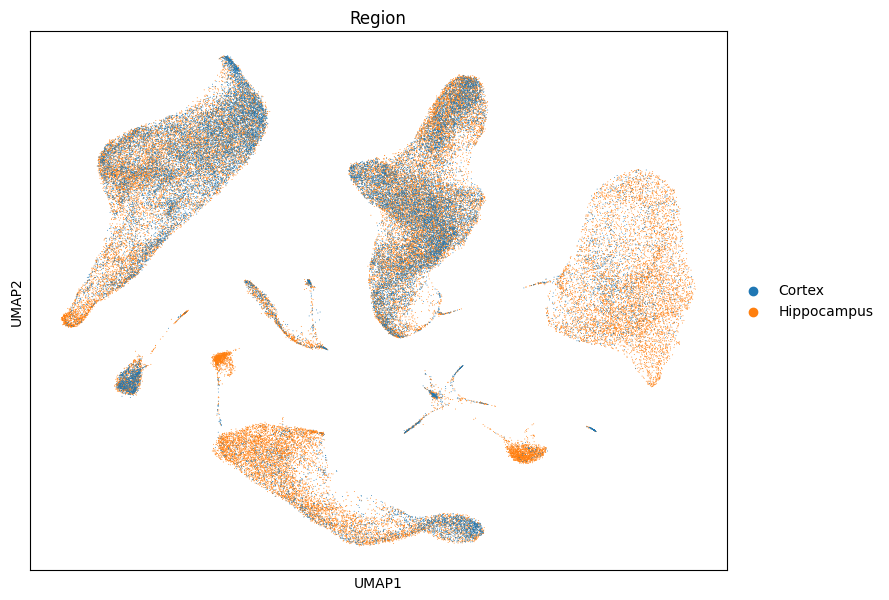

In [37]:
with rc_context({'figure.figsize': (9, 7)}):
    sc.pl.umap(ad, color=['Region'])

In [38]:
pd.crosstab(ad.obs["clusters"], ad.obs["Region"])

Region                 Cortex  Hippocampus
clusters                                  
Astrocytes               2110         7833
ECs                      9519        15463
Ependymal cells            40          845
Fibroblasts               820         1212
Microglia/Macrophages     325          817
Neurons                   403          530
OPCs                       42         1467
Oligos                   1440         7088
Pericytes                7689         9872
SMCs                     1411         3258
T cells                    72          115

In [39]:
adata=ad

In [40]:
del ad

# Standard pipeline

Skip, because data is pre-analyzed.

Check if data is normalized:

In [41]:
adata.layers

Layers with keys: 

In [42]:
adata.X

<72371x23537 sparse matrix of type '<class 'numpy.float32'>'
	with 50047119 stored elements in Compressed Sparse Row format>

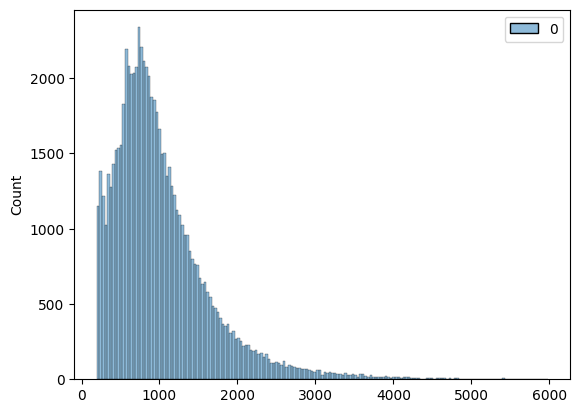

In [43]:
sns.histplot(adata.X.sum(1), kde=False)
plt.show()

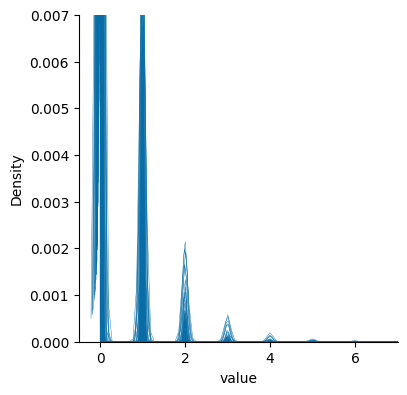

In [44]:
# show expression of 100 random genes (across all spots)
random_genes=random.sample(range(0, adata.X.shape[1]), 100)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl1=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl1.set(xlim=(-0.5, 7),ylim=(0,0.007));
plt.show()

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_6484\2801705899.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100))) # genes with 0 expression are excluded


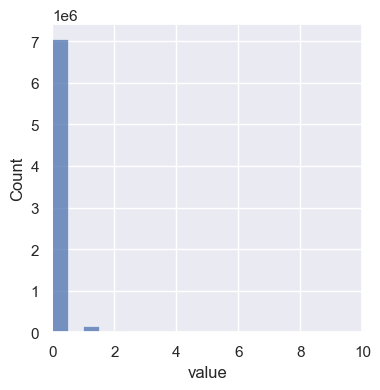

In [45]:
sns.set(rc={'figure.figsize':(4,4)})
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100))) # genes with 0 expression are excluded
pl.set(xlim=(0, 10));
sns.set_style("ticks")
plt.show()

Data is not normalized, therefore normalize and log-transform

In [46]:
adata.layers["counts"] = adata.X.copy() # save unnormalized raw RNA counts - retrieve via ad.X = ad.layers["counts"]

In [47]:
sc.pp.normalize_total(adata, inplace=True) # Normalize each spot by total counts over all genes, so that every spot has the same total count after normalization.

normalizing counts per cell
    finished (0:00:00)


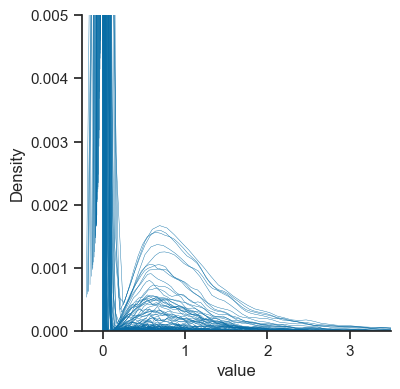

In [48]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.3) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005))
plt.show()

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_6484\1415531030.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100))) # genes with 0 expression are excluded


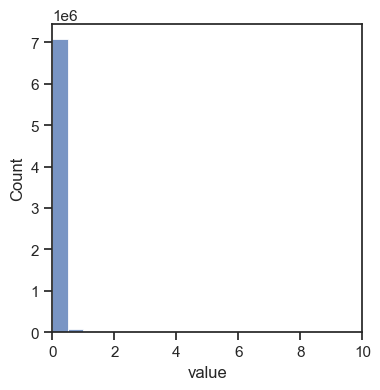

In [49]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100))) # genes with 0 expression are excluded
pl.set(xlim=(0, 10))
plt.show()

In [50]:
sc.pp.log1p(adata) # X = log(X + 1)

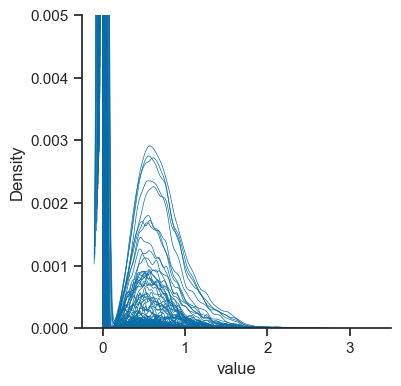

In [51]:
# show expression of 100 random genes (across all spots)
adata_sub = adata[:,random_genes]
exp=pd.DataFrame(adata_sub.X.todense())
# plot
pl=sns.displot(data=pd.melt(exp),x='value',height=4,hue='variable',kind="kde",warn_singular=False,legend=False,palette=list(np.repeat('#086da6',100)), lw=0.5) # genes with 0 expression are excluded
pl.set(xlim=(-0.25, 3.5),ylim=(0,0.005));
plt.show()

C:\Users\sfrerich\AppData\Local\Temp\ipykernel_6484\3704009479.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100))); # genes with 0 expression are excluded


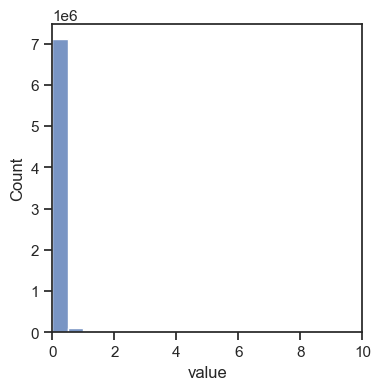

In [52]:
pl=sns.histplot(data=pd.melt(exp),x='value',binwidth=0.5,legend=True,palette=list(np.repeat('#086da6',100))); # genes with 0 expression are excluded
pl.set(xlim=(0, 10));
plt.show()

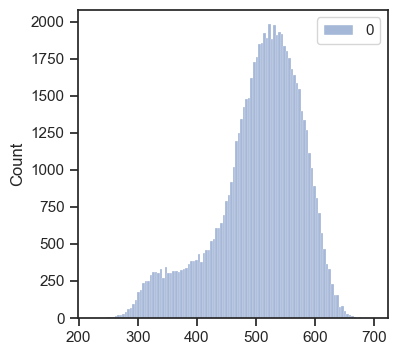

In [53]:
sns.histplot(adata.X.sum(1), kde=False)
plt.show()

In [54]:
adata.layers["normalized"] = adata.X.copy() # save normalized + log-transformed (but unscaled) counts - retrieve via adata.X = adata.layers["normalized"]

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


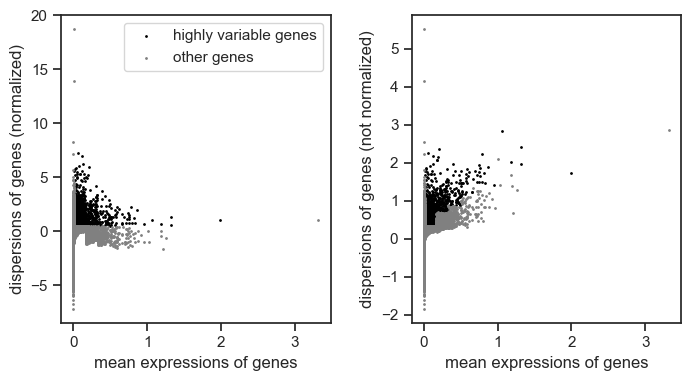

In [55]:
# Identify highly-variable genes
sc.pp.highly_variable_genes(adata)
sc.pl.highly_variable_genes(adata)

In [56]:
adata

AnnData object with n_obs × n_vars = 72371 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type', 'clusters2', 'clusters'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_Type_colors', 'clusters_colors', 'clusters2_colors', 'Region_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [57]:
adata.layers

Layers with keys: counts, normalized

# Vascular marker genes

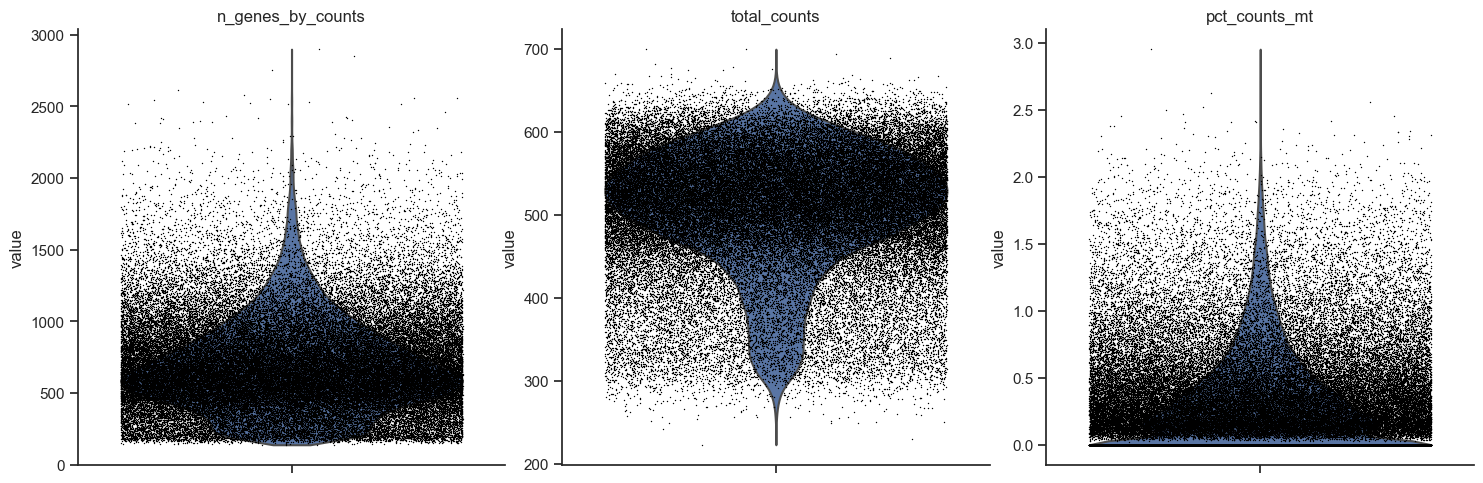

In [58]:
# Basic QC metrics
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],jitter=0.4, multi_panel=True)

In [ ]:
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon', key_added='clusters')

In [ ]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key='clusters')

Export DEG table

In [ ]:
sc.tl.rank_genes_groups(adata, 'clusters', method='wilcoxon')

ranking genes


In [82]:
# export DEG table
celltypes = adata.obs.clusters.unique().tolist()
merged_df = pd.DataFrame()
for group in celltypes:
    rank_df = rank_genes_groups_df(adata=adata, group=group, adj_pval_cutoff=None, log2fc_cutoff=None, sortby='zscore')
    merged_df = pd.concat([merged_df, rank_df])
    merged_df['reference'] = 'all other clusters'
merged_df.head(3)

divide by zero encountered in log10


gene    log2FC         FC  pvals  pvals_adj  \
ST6GALNAC3  ST6GALNAC3  4.155408  17.819790    0.0        0.0   
FLT1              FLT1  4.654848  25.191202    0.0        0.0   
ELOVL7          ELOVL7  4.711992  26.209024    0.0        0.0   

            nlog10_pval_adj      zscore group           reference  
ST6GALNAC3              inf  198.513687   ECs  all other clusters  
FLT1                    inf  193.377121   ECs  all other clusters  
ELOVL7                  inf  177.873337   ECs  all other clusters

In [85]:
merged_df.group.unique().tolist()

['ECs',
 'T cells',
 'SMCs',
 'Pericytes',
 'Oligos',
 'Fibroblasts',
 'Ependymal cells',
 'Microglia/Macrophages',
 'Astrocytes',
 'OPCs',
 'Neurons']

In [84]:
# export as csv
merged_df.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\DEA\\'+ date.today().strftime("%Y%m%d")+'_DE_genes_Yang2022.csv',sep=';')

In [87]:
sc.tl.rank_genes_groups(adata, 'clusters2', method='wilcoxon', key_added='clusters2')

ranking genes
    finished: added to `.uns['clusters2']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:02:59)


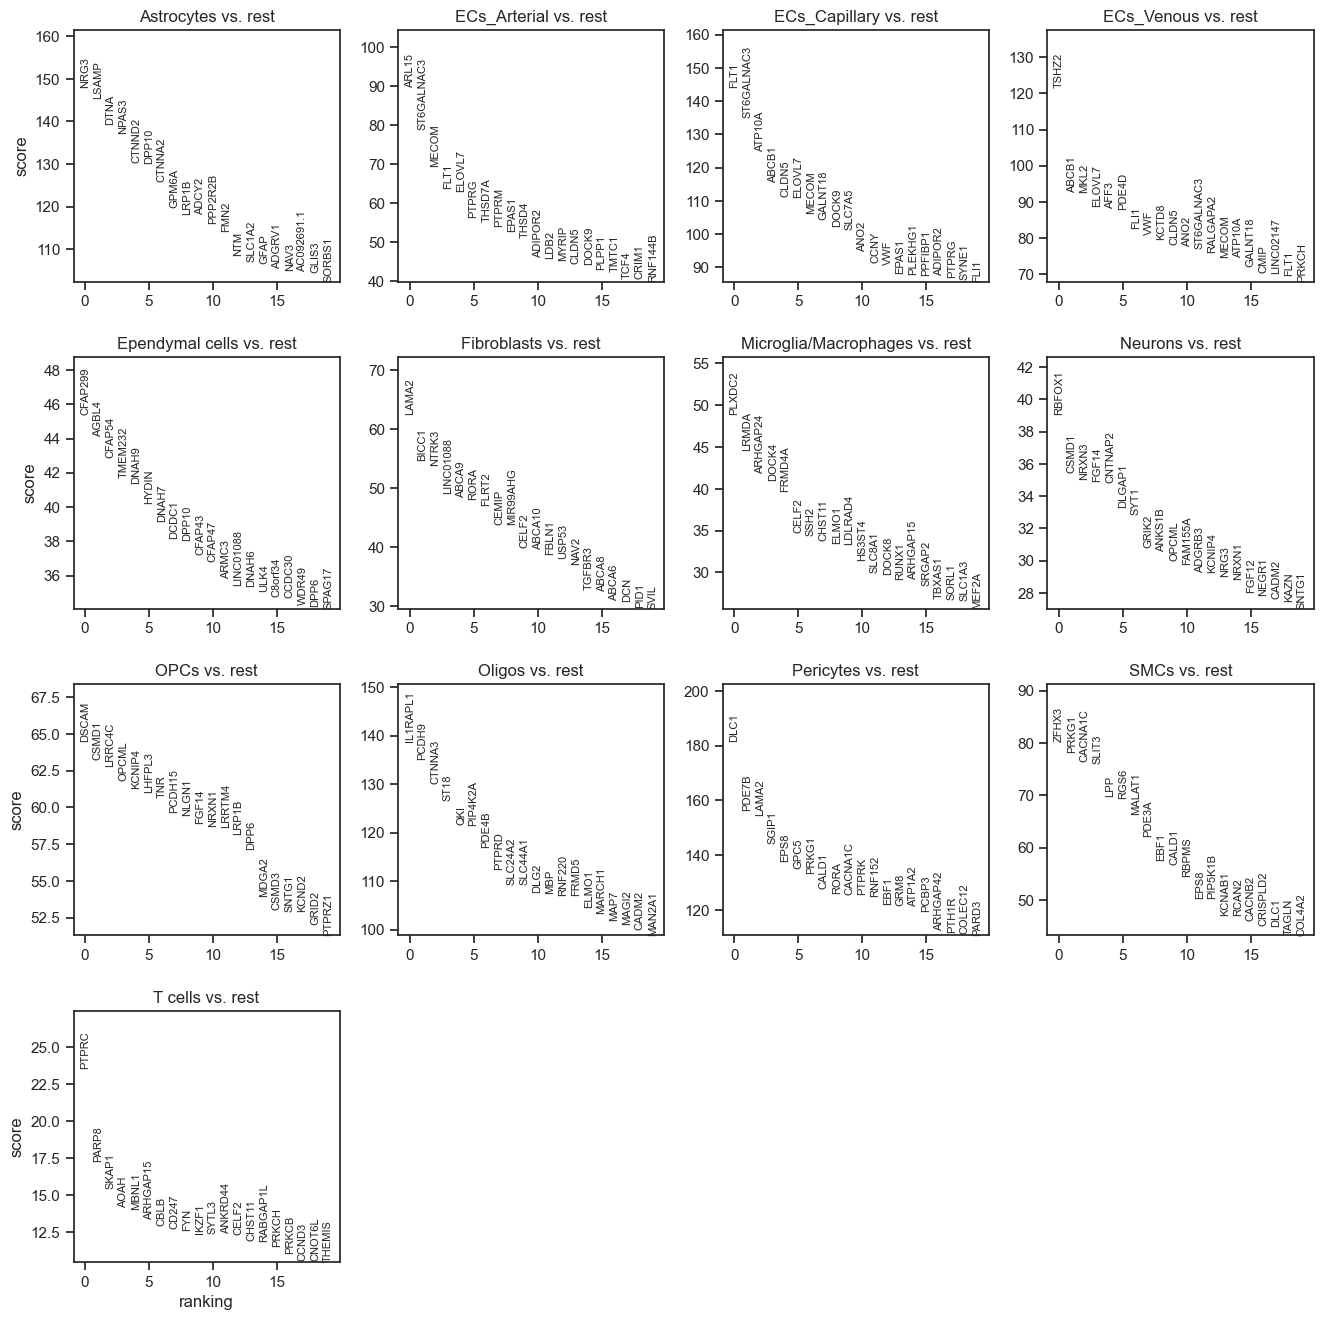

In [88]:
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False, key='clusters2')

Export DEG table

In [92]:
sc.tl.rank_genes_groups(adata, 'clusters2', method='wilcoxon')

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:03:02)


In [93]:
celltypes = adata.obs.clusters2.unique().tolist()
merged_df = pd.DataFrame()
for group in celltypes:
    rank_df = rank_genes_groups_df(adata=adata, group=group, adj_pval_cutoff=None, log2fc_cutoff=None, sortby='zscore')
    merged_df = pd.concat([merged_df, rank_df])
    merged_df['reference'] = 'all other clusters'
merged_df.head(3)

divide by zero encountered in log10


gene    log2FC         FC  pvals  pvals_adj  nlog10_pval_adj  \
TSHZ2  TSHZ2  5.022112  32.494236    0.0        0.0              inf   
ABCB1  ABCB1  2.636389   6.217733    0.0        0.0              inf   
MKL2    MKL2  2.642808   6.245462    0.0        0.0              inf   

           zscore       group           reference  
TSHZ2  121.440292  ECs_Venous  all other clusters  
ABCB1   92.651718  ECs_Venous  all other clusters  
MKL2    92.392746  ECs_Venous  all other clusters

In [94]:
merged_df.group.unique().tolist()

['ECs_Venous',
 'T cells',
 'SMCs',
 'Pericytes',
 'ECs_Capillary',
 'ECs_Arterial',
 'Oligos',
 'Fibroblasts',
 'Ependymal cells',
 'Microglia/Macrophages',
 'Astrocytes',
 'OPCs',
 'Neurons']

In [95]:
# export as csv
merged_df.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\DEA\\'+ date.today().strftime("%Y%m%d")+'_DE_genes_Yang2022_incl_zonation.csv',sep=';')

# Focus on: Foxf2

In [49]:
gene="FOXF2"

## Plot

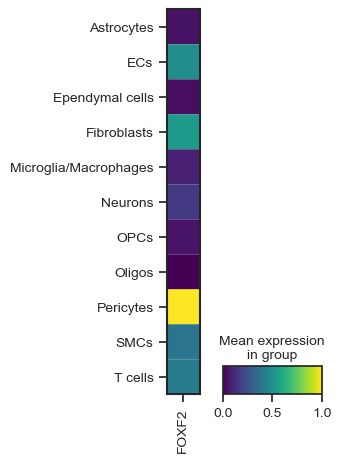

In [50]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

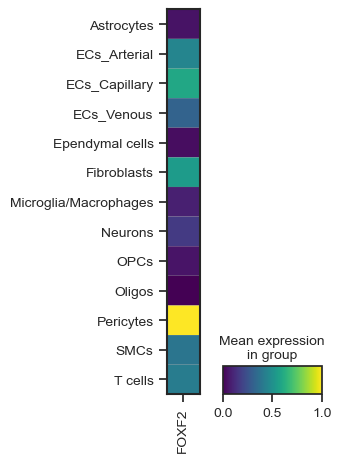

In [50]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

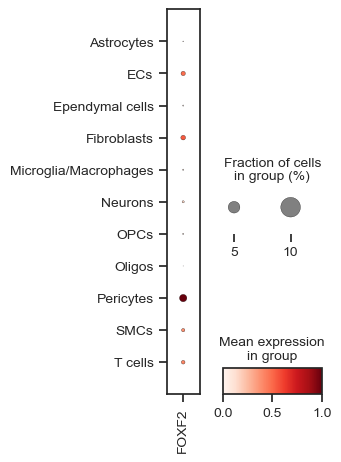

In [51]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

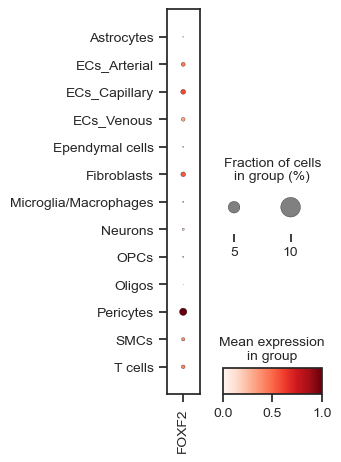

In [52]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

## Excl zonation

In [53]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.046944
ECs                           0.490284
Ependymal cells               0.034462
Fibroblasts                   0.545060
Microglia/Macrophages         0.086930
Neurons                       0.168198
OPCs                          0.052711
Oligos                        0.000000
Pericytes                     1.000000
SMCs                          0.388030
T cells                       0.417895

In [54]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.001307
ECs                             0.013450
Ependymal cells                 0.002260
Fibroblasts                     0.014764
Microglia/Macrophages           0.002627
Neurons                         0.005359
OPCs                            0.002651
Oligos                          0.000352
Pericytes                       0.026878
SMCs                            0.009424
T cells                         0.010695

In [55]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells   gene    source  \
clusters                                                                     
Astrocytes                    0.046944           0.001307  FOXF2  Yang2022   
ECs                           0.490284           0.013450  FOXF2  Yang2022   
Ependymal cells               0.034462           0.002260  FOXF2  Yang2022   
Fibroblasts                   0.545060           0.014764  FOXF2  Yang2022   
Microglia/Macrophages         0.086930           0.002627  FOXF2  Yang2022   
Neurons                       0.168198           0.005359  FOXF2  Yang2022   
OPCs                          0.052711           0.002651  FOXF2  Yang2022   
Oligos                        0.000000           0.000352  FOXF2  Yang2022   
Pericytes                     1.000000           0.026878  FOXF2  Yang2022   
SMCs                          0.388030           0.009424  FOXF2  Yang2022   
T cells                       0.417895           0.010695  FOXF2  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [56]:
# export
name='Yang2022'

In [57]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_normalized.csv',sep=';')

## Incl zonation

In [58]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [59]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [60]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells   gene    source  \
clusters2                                                                    
Astrocytes                    0.046944           0.001307  FOXF2  Yang2022   
ECs_Arterial                  0.455379           0.011815  FOXF2  Yang2022   
ECs_Capillary                 0.595828           0.015273  FOXF2  Yang2022   
ECs_Venous                    0.314746           0.011066  FOXF2  Yang2022   
Ependymal cells               0.034462           0.002260  FOXF2  Yang2022   
Fibroblasts                   0.545060           0.014764  FOXF2  Yang2022   
Microglia/Macrophages         0.086930           0.002627  FOXF2  Yang2022   
Neurons                       0.168198           0.005359  FOXF2  Yang2022   
OPCs                          0.052711           0.002651  FOXF2  Yang2022   
Oligos                        0.000000           0.000352  FOXF2  Yang2022   
Pericytes                     1.000000           0.026878  FOXF2  Yang2022   
SMCs                          0.388030           0.009424  FOXF2  Yang2022   
T cells                       0.417895           0.010695  FOXF2  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [61]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Foxf2_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+name+'_incl_zonation_normalized.csv',sep=';')

# Focus on: Other genes

## Foxo1

In [62]:
gene="FOXO1"

### Plot

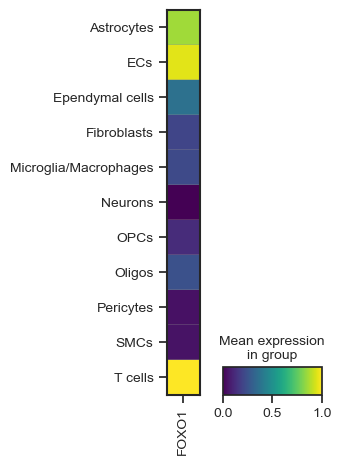

In [63]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

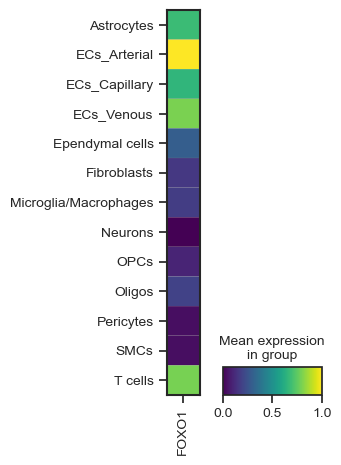

In [64]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

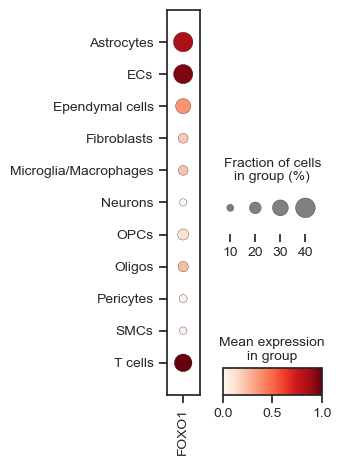

In [65]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

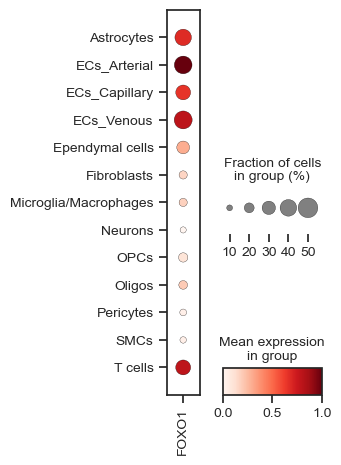

In [66]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [67]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.859098
ECs                           0.953482
Ependymal cells               0.369467
Fibroblasts                   0.203891
Microglia/Macrophages         0.225142
Neurons                       0.000000
OPCs                          0.123307
Oligos                        0.248102
Pericytes                     0.046024
SMCs                          0.047287
T cells                       1.000000

In [68]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.397063
ECs                             0.389320
Ependymal cells                 0.281356
Fibroblasts                     0.156988
Microglia/Macrophages           0.155867
Neurons                         0.107181
OPCs                            0.185553
Oligos                          0.169442
Pericytes                       0.121633
SMCs                            0.113943
T cells                         0.347594

In [69]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells   gene    source  \
clusters                                                                     
Astrocytes                    0.859098           0.397063  FOXO1  Yang2022   
ECs                           0.953482           0.389320  FOXO1  Yang2022   
Ependymal cells               0.369467           0.281356  FOXO1  Yang2022   
Fibroblasts                   0.203891           0.156988  FOXO1  Yang2022   
Microglia/Macrophages         0.225142           0.155867  FOXO1  Yang2022   
Neurons                       0.000000           0.107181  FOXO1  Yang2022   
OPCs                          0.123307           0.185553  FOXO1  Yang2022   
Oligos                        0.248102           0.169442  FOXO1  Yang2022   
Pericytes                     0.046024           0.121633  FOXO1  Yang2022   
SMCs                          0.047287           0.113943  FOXO1  Yang2022   
T cells                       1.000000           0.347594  FOXO1  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [70]:
# export
name='Yang2022'

In [71]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [72]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [73]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [74]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells   gene    source  \
clusters2                                                                    
Astrocytes                    0.682821           0.397063  FOXO1  Yang2022   
ECs_Arterial                  1.000000           0.435577  FOXO1  Yang2022   
ECs_Capillary                 0.653903           0.344538  FOXO1  Yang2022   
ECs_Venous                    0.800131           0.444040  FOXO1  Yang2022   
Ependymal cells               0.293657           0.281356  FOXO1  Yang2022   
Fibroblasts                   0.162055           0.156988  FOXO1  Yang2022   
Microglia/Macrophages         0.178946           0.155867  FOXO1  Yang2022   
Neurons                       0.000000           0.107181  FOXO1  Yang2022   
OPCs                          0.098006           0.185553  FOXO1  Yang2022   
Oligos                        0.197194           0.169442  FOXO1  Yang2022   
Pericytes                     0.036580           0.121633  FOXO1  Yang2022   
SMCs                          0.037585           0.113943  FOXO1  Yang2022   
T cells                       0.794811           0.347594  FOXO1  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [75]:
# export
name='Yang2022'

In [76]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## Tek = Tie2

In [77]:
gene="TEK"

### Plot

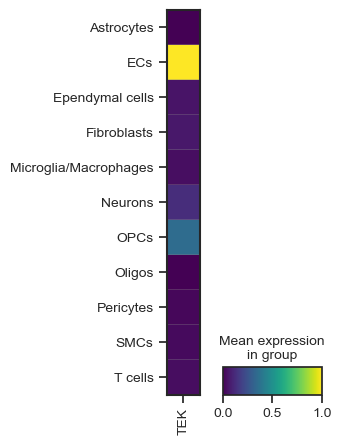

In [78]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

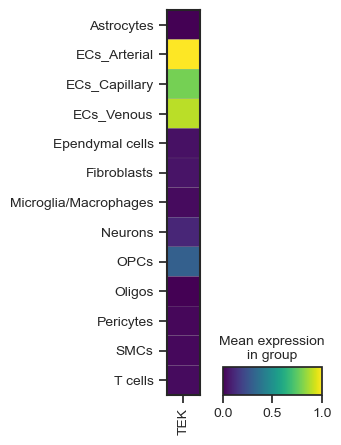

In [79]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

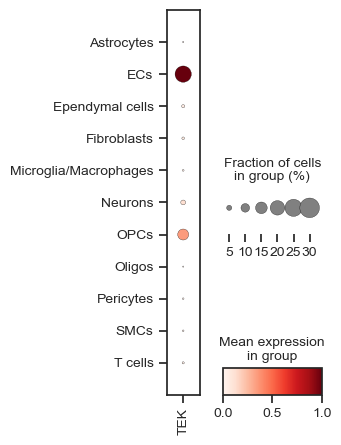

In [80]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

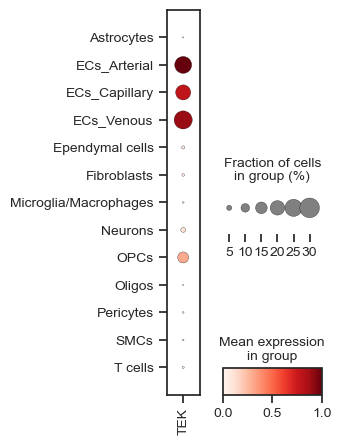

In [81]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [82]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.000000
ECs                           1.000000
Ependymal cells               0.052491
Fibroblasts                   0.063011
Microglia/Macrophages         0.035701
Neurons                       0.126694
OPCs                          0.351236
Oligos                        0.002713
Pericytes                     0.018395
SMCs                          0.026857
T cells                       0.034876

In [83]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.008247
ECs                             0.233888
Ependymal cells                 0.025989
Fibroblasts                     0.020669
Microglia/Macrophages           0.012259
Neurons                         0.046088
OPCs                            0.138502
Oligos                          0.007153
Pericytes                       0.011104
SMCs                            0.011137
T cells                         0.016043

In [84]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells gene    source  \
clusters                                                                   
Astrocytes                    0.000000           0.008247  TEK  Yang2022   
ECs                           1.000000           0.233888  TEK  Yang2022   
Ependymal cells               0.052491           0.025989  TEK  Yang2022   
Fibroblasts                   0.063011           0.020669  TEK  Yang2022   
Microglia/Macrophages         0.035701           0.012259  TEK  Yang2022   
Neurons                       0.126694           0.046088  TEK  Yang2022   
OPCs                          0.351236           0.138502  TEK  Yang2022   
Oligos                        0.002713           0.007153  TEK  Yang2022   
Pericytes                     0.018395           0.011104  TEK  Yang2022   
SMCs                          0.026857           0.011137  TEK  Yang2022   
T cells                       0.034876           0.016043  TEK  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [85]:
# export
name='Yang2022'

In [86]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [87]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [88]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [89]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells gene    source  \
clusters2                                                                  
Astrocytes                    0.000000           0.008247  TEK  Yang2022   
ECs_Arterial                  1.000000           0.245876  TEK  Yang2022   
ECs_Capillary                 0.791450           0.210826  TEK  Yang2022   
ECs_Venous                    0.897224           0.269506  TEK  Yang2022   
Ependymal cells               0.045097           0.025989  TEK  Yang2022   
Fibroblasts                   0.054135           0.020669  TEK  Yang2022   
Microglia/Macrophages         0.030672           0.012259  TEK  Yang2022   
Neurons                       0.108846           0.046088  TEK  Yang2022   
OPCs                          0.301756           0.138502  TEK  Yang2022   
Oligos                        0.002331           0.007153  TEK  Yang2022   
Pericytes                     0.015804           0.011104  TEK  Yang2022   
SMCs                          0.023074           0.011137  TEK  Yang2022   
T cells                       0.029963           0.016043  TEK  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [90]:
# export
name='Yang2022'

In [91]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## Nos3 = eNOS

In [92]:
gene="NOS3"

### Plot

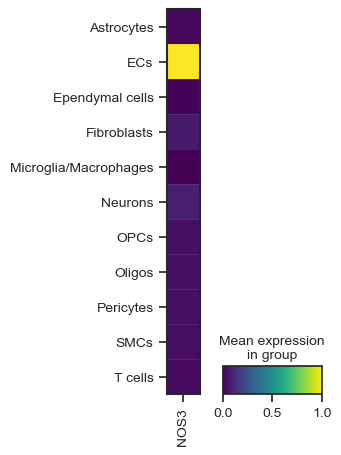

In [93]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

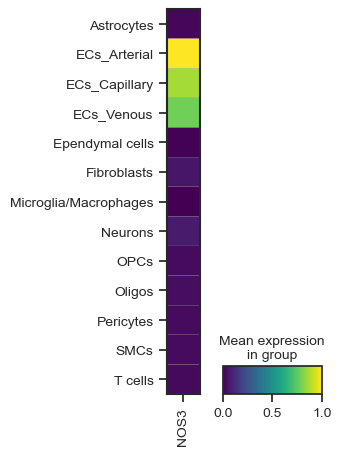

In [94]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

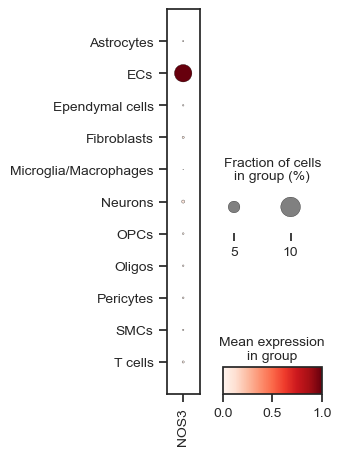

In [95]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

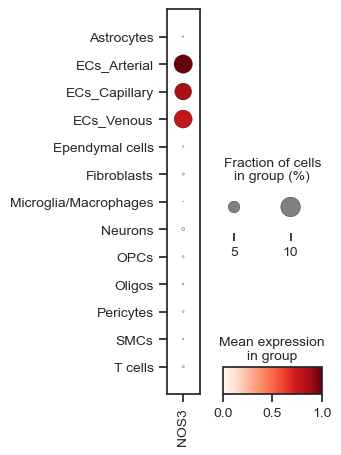

In [96]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [97]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.021332
ECs                           1.000000
Ependymal cells               0.006166
Fibroblasts                   0.066724
Microglia/Macrophages         0.000000
Neurons                       0.084413
OPCs                          0.033535
Oligos                        0.037134
Pericytes                     0.034082
SMCs                          0.032471
T cells                       0.030276

In [98]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.002816
ECs                             0.085702
Ependymal cells                 0.003390
Fibroblasts                     0.005413
Microglia/Macrophages           0.000876
Neurons                         0.008574
OPCs                            0.003976
Oligos                          0.003635
Pericytes                       0.003929
SMCs                            0.003213
T cells                         0.005348

In [99]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells  gene    source  \
clusters                                                                    
Astrocytes                    0.021332           0.002816  NOS3  Yang2022   
ECs                           1.000000           0.085702  NOS3  Yang2022   
Ependymal cells               0.006166           0.003390  NOS3  Yang2022   
Fibroblasts                   0.066724           0.005413  NOS3  Yang2022   
Microglia/Macrophages         0.000000           0.000876  NOS3  Yang2022   
Neurons                       0.084413           0.008574  NOS3  Yang2022   
OPCs                          0.033535           0.003976  NOS3  Yang2022   
Oligos                        0.037134           0.003635  NOS3  Yang2022   
Pericytes                     0.034082           0.003929  NOS3  Yang2022   
SMCs                          0.032471           0.003213  NOS3  Yang2022   
T cells                       0.030276           0.005348  NOS3  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [100]:
# export
name='Yang2022'

In [101]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [102]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [103]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [104]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells  gene    source  \
clusters2                                                                   
Astrocytes                    0.018469           0.002816  NOS3  Yang2022   
ECs_Arterial                  1.000000           0.091841  NOS3  Yang2022   
ECs_Capillary                 0.863957           0.081755  NOS3  Yang2022   
ECs_Venous                    0.784895           0.089228  NOS3  Yang2022   
Ependymal cells               0.005338           0.003390  NOS3  Yang2022   
Fibroblasts                   0.057769           0.005413  NOS3  Yang2022   
Microglia/Macrophages         0.000000           0.000876  NOS3  Yang2022   
Neurons                       0.073084           0.008574  NOS3  Yang2022   
OPCs                          0.029034           0.003976  NOS3  Yang2022   
Oligos                        0.032150           0.003635  NOS3  Yang2022   
Pericytes                     0.029508           0.003929  NOS3  Yang2022   
SMCs                          0.028113           0.003213  NOS3  Yang2022   
T cells                       0.026213           0.005348  NOS3  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [105]:
# export
name='Yang2022'

In [106]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## HTRA1

In [51]:
gene="HTRA1"

### Plot

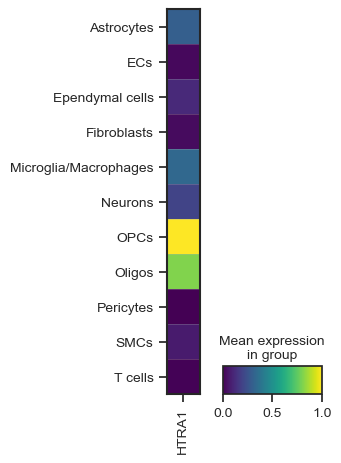

In [52]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

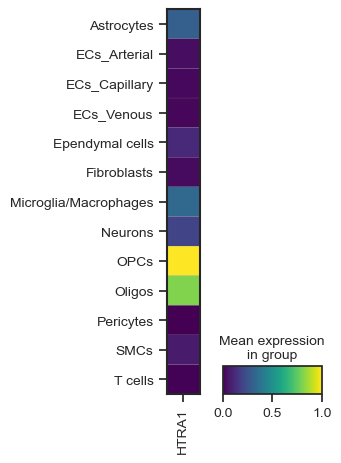

In [53]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

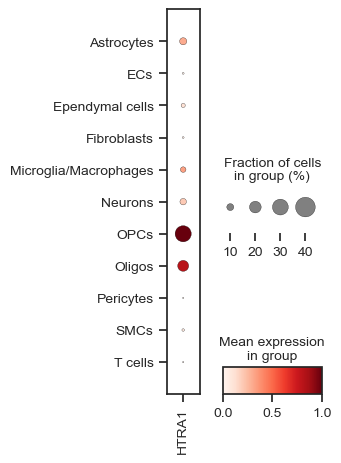

In [54]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

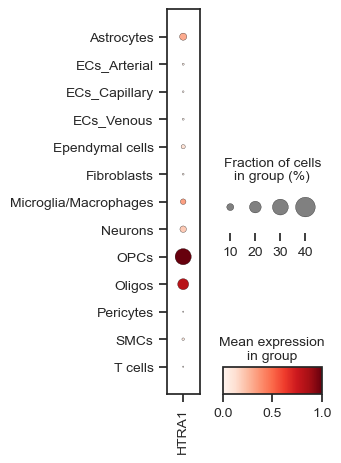

In [55]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [56]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.299464
ECs                           0.022093
Ependymal cells               0.116547
Fibroblasts                   0.029907
Microglia/Macrophages         0.332597
Neurons                       0.200246
OPCs                          1.000000
Oligos                        0.810460
Pericytes                     0.000000
SMCs                          0.070670
T cells                       0.006214

In [57]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.104093
ECs                             0.017092
Ependymal cells                 0.050847
Fibroblasts                     0.016732
Microglia/Macrophages           0.074431
Neurons                         0.091104
OPCs                            0.308151
Oligos                          0.184217
Pericytes                       0.010421
SMCs                            0.026344
T cells                         0.010695

In [58]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells   gene    source  \
clusters                                                                     
Astrocytes                    0.299464           0.104093  HTRA1  Yang2022   
ECs                           0.022093           0.017092  HTRA1  Yang2022   
Ependymal cells               0.116547           0.050847  HTRA1  Yang2022   
Fibroblasts                   0.029907           0.016732  HTRA1  Yang2022   
Microglia/Macrophages         0.332597           0.074431  HTRA1  Yang2022   
Neurons                       0.200246           0.091104  HTRA1  Yang2022   
OPCs                          1.000000           0.308151  HTRA1  Yang2022   
Oligos                        0.810460           0.184217  HTRA1  Yang2022   
Pericytes                     0.000000           0.010421  HTRA1  Yang2022   
SMCs                          0.070670           0.026344  HTRA1  Yang2022   
T cells                       0.006214           0.010695  HTRA1  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [59]:
# export
name='Yang2022'

In [60]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [61]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [62]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [63]:
foxf2 = pd.concat([ex, fc], axis=1)
foxf2['gene'] = gene
foxf2['source'] = "Yang2022"
foxf2['organism'] = "Human"
foxf2['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(foxf2.index)
foxf2

mean_expression  fraction_of_cells   gene    source  \
clusters2                                                                    
Astrocytes                    0.299464           0.104093  HTRA1  Yang2022   
ECs_Arterial                  0.033481           0.019394  HTRA1  Yang2022   
ECs_Capillary                 0.019797           0.015497  HTRA1  Yang2022   
ECs_Venous                    0.019234           0.018630  HTRA1  Yang2022   
Ependymal cells               0.116547           0.050847  HTRA1  Yang2022   
Fibroblasts                   0.029907           0.016732  HTRA1  Yang2022   
Microglia/Macrophages         0.332597           0.074431  HTRA1  Yang2022   
Neurons                       0.200246           0.091104  HTRA1  Yang2022   
OPCs                          1.000000           0.308151  HTRA1  Yang2022   
Oligos                        0.810460           0.184217  HTRA1  Yang2022   
Pericytes                     0.000000           0.010421  HTRA1  Yang2022   
SMCs                          0.070670           0.026344  HTRA1  Yang2022   
T cells                       0.006214           0.010695  HTRA1  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [64]:
# export
name='Yang2022'

In [65]:
# Win
foxf2.to_csv(main_dir+'\\P6_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## EGFL8

In [60]:
gene="EGFL8"

In [62]:
# not in dataset

### Plot

In [ ]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

## FLT1

In [63]:
gene="FLT1"

### Plot

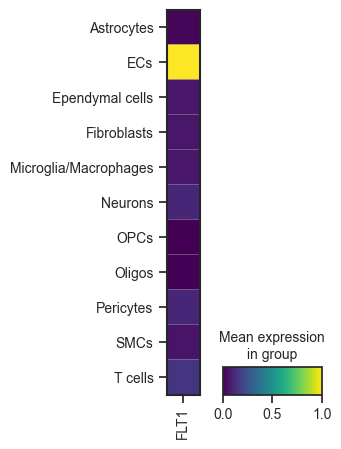

In [64]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

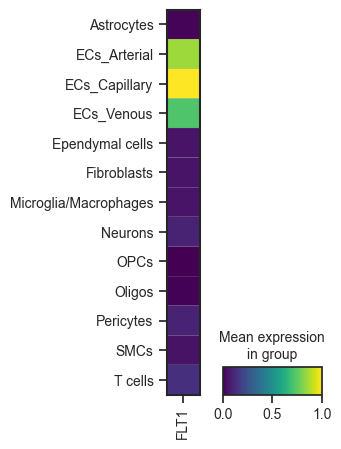

In [65]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


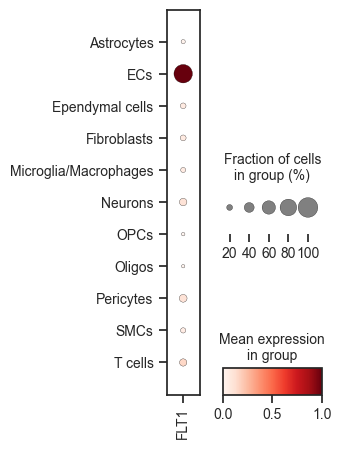

In [66]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


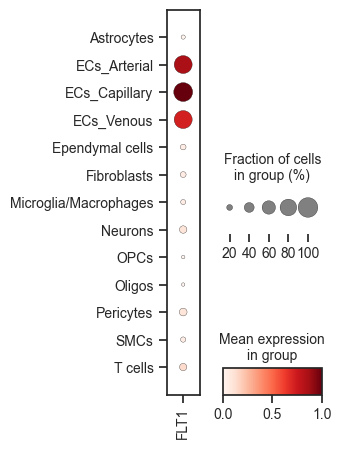

In [67]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [68]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.012571
ECs                           1.000000
Ependymal cells               0.058789
Fibroblasts                   0.060965
Microglia/Macrophages         0.059892
Neurons                       0.106543
OPCs                          0.000000
Oligos                        0.007441
Pericytes                     0.108297
SMCs                          0.052402
T cells                       0.155285

In [69]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.127929
ECs                             0.921063
Ependymal cells                 0.192090
Fibroblasts                     0.198327
Microglia/Macrophages           0.164623
Neurons                         0.275456
OPCs                            0.102054
Oligos                          0.097678
Pericytes                       0.289334
SMCs                            0.174127
T cells                         0.267380

In [71]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells  gene    source  \
clusters                                                                    
Astrocytes                    0.012571           0.127929  FLT1  Yang2022   
ECs                           1.000000           0.921063  FLT1  Yang2022   
Ependymal cells               0.058789           0.192090  FLT1  Yang2022   
Fibroblasts                   0.060965           0.198327  FLT1  Yang2022   
Microglia/Macrophages         0.059892           0.164623  FLT1  Yang2022   
Neurons                       0.106543           0.275456  FLT1  Yang2022   
OPCs                          0.000000           0.102054  FLT1  Yang2022   
Oligos                        0.007441           0.097678  FLT1  Yang2022   
Pericytes                     0.108297           0.289334  FLT1  Yang2022   
SMCs                          0.052402           0.174127  FLT1  Yang2022   
T cells                       0.155285           0.267380  FLT1  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [72]:
# export
name='Yang2022'

In [73]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [74]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [75]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [76]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells  gene    source  \
clusters2                                                                   
Astrocytes                    0.011246           0.127929  FLT1  Yang2022   
ECs_Arterial                  0.853649           0.886536  FLT1  Yang2022   
ECs_Capillary                 1.000000           0.948342  FLT1  Yang2022   
ECs_Venous                    0.723051           0.891722  FLT1  Yang2022   
Ependymal cells               0.052591           0.192090  FLT1  Yang2022   
Fibroblasts                   0.054538           0.198327  FLT1  Yang2022   
Microglia/Macrophages         0.053578           0.164623  FLT1  Yang2022   
Neurons                       0.095311           0.275456  FLT1  Yang2022   
OPCs                          0.000000           0.102054  FLT1  Yang2022   
Oligos                        0.006657           0.097678  FLT1  Yang2022   
Pericytes                     0.096880           0.289334  FLT1  Yang2022   
SMCs                          0.046877           0.174127  FLT1  Yang2022   
T cells                       0.138915           0.267380  FLT1  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [77]:
# export
name='Yang2022'

In [78]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## KDR

In [81]:
gene="KDR"

### Plot

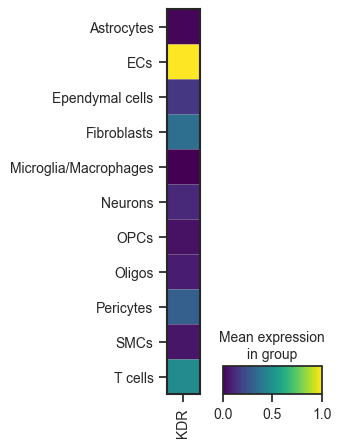

In [82]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

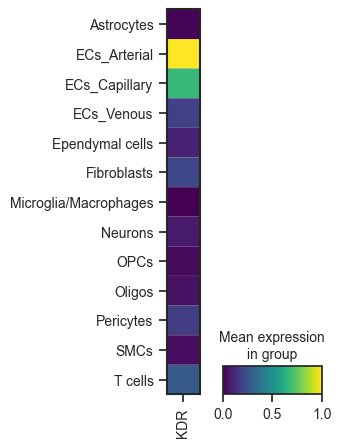

In [83]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


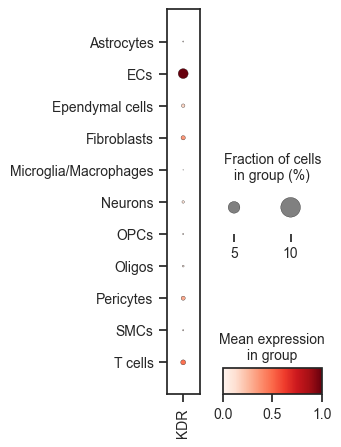

In [84]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


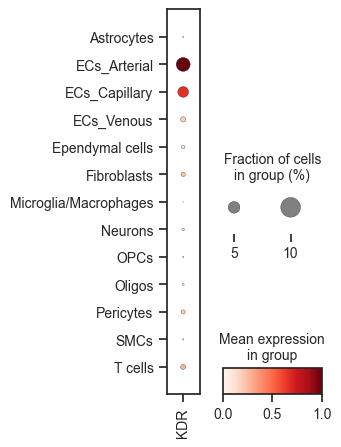

In [85]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [86]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.014059
ECs                           1.000000
Ependymal cells               0.159257
Fibroblasts                   0.358536
Microglia/Macrophages         0.000000
Neurons                       0.112477
OPCs                          0.045918
Oligos                        0.078879
Pericytes                     0.298064
SMCs                          0.057398
T cells                       0.474929

In [87]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.002213
ECs                             0.040149
Ependymal cells                 0.010169
Fibroblasts                     0.013287
Microglia/Macrophages           0.000876
Neurons                         0.006431
OPCs                            0.002651
Oligos                          0.004339
Pericytes                       0.012414
SMCs                            0.002784
T cells                         0.016043

In [88]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells gene    source  \
clusters                                                                   
Astrocytes                    0.014059           0.002213  KDR  Yang2022   
ECs                           1.000000           0.040149  KDR  Yang2022   
Ependymal cells               0.159257           0.010169  KDR  Yang2022   
Fibroblasts                   0.358536           0.013287  KDR  Yang2022   
Microglia/Macrophages         0.000000           0.000876  KDR  Yang2022   
Neurons                       0.112477           0.006431  KDR  Yang2022   
OPCs                          0.045918           0.002651  KDR  Yang2022   
Oligos                        0.078879           0.004339  KDR  Yang2022   
Pericytes                     0.298064           0.012414  KDR  Yang2022   
SMCs                          0.057398           0.002784  KDR  Yang2022   
T cells                       0.474929           0.016043  KDR  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [89]:
# export
name='Yang2022'

In [90]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [91]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [92]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [93]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells gene    source  \
clusters2                                                                  
Astrocytes                    0.008316           0.002213  KDR  Yang2022   
ECs_Arterial                  1.000000           0.063085  KDR  Yang2022   
ECs_Capillary                 0.669751           0.044771  KDR  Yang2022   
ECs_Venous                    0.188326           0.017089  KDR  Yang2022   
Ependymal cells               0.094197           0.010169  KDR  Yang2022   
Fibroblasts                   0.212067           0.013287  KDR  Yang2022   
Microglia/Macrophages         0.000000           0.000876  KDR  Yang2022   
Neurons                       0.066528           0.006431  KDR  Yang2022   
OPCs                          0.027159           0.002651  KDR  Yang2022   
Oligos                        0.046655           0.004339  KDR  Yang2022   
Pericytes                     0.176298           0.012414  KDR  Yang2022   
SMCs                          0.033950           0.002784  KDR  Yang2022   
T cells                       0.280911           0.016043  KDR  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [94]:
# export
name='Yang2022'

In [95]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## NRP1

In [96]:
gene="NRP1"

### Plot

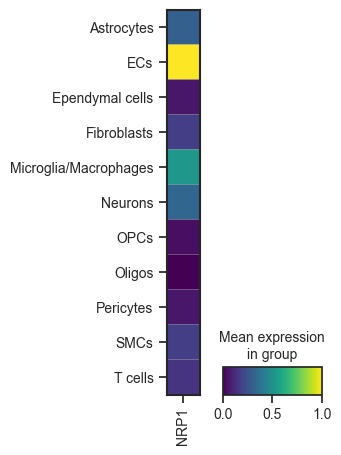

In [97]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

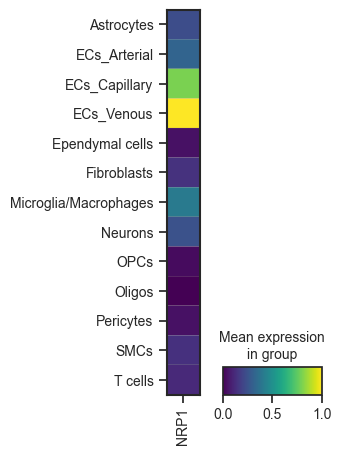

In [98]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


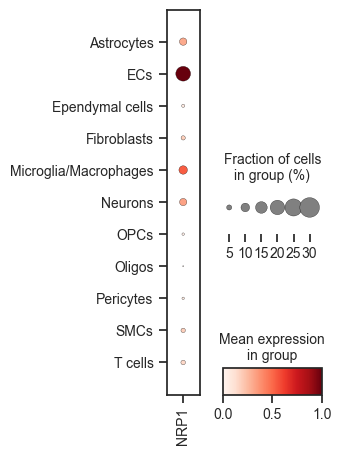

In [99]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


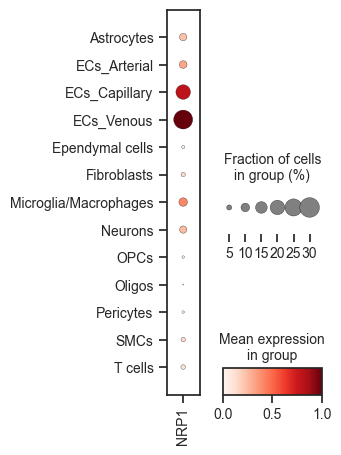

In [100]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [101]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.302370
ECs                           1.000000
Ependymal cells               0.060000
Fibroblasts                   0.183580
Microglia/Macrophages         0.532543
Neurons                       0.328087
OPCs                          0.037854
Oligos                        0.000000
Pericytes                     0.060632
SMCs                          0.179961
T cells                       0.151524

In [102]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.081565
ECs                             0.204507
Ependymal cells                 0.025989
Fibroblasts                     0.039370
Microglia/Macrophages           0.098074
Neurons                         0.079314
OPCs                            0.019218
Oligos                          0.006098
Pericytes                       0.018849
SMCs                            0.041336
T cells                         0.042781

In [103]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells  gene    source  \
clusters                                                                    
Astrocytes                    0.302370           0.081565  NRP1  Yang2022   
ECs                           1.000000           0.204507  NRP1  Yang2022   
Ependymal cells               0.060000           0.025989  NRP1  Yang2022   
Fibroblasts                   0.183580           0.039370  NRP1  Yang2022   
Microglia/Macrophages         0.532543           0.098074  NRP1  Yang2022   
Neurons                       0.328087           0.079314  NRP1  Yang2022   
OPCs                          0.037854           0.019218  NRP1  Yang2022   
Oligos                        0.000000           0.006098  NRP1  Yang2022   
Pericytes                     0.060632           0.018849  NRP1  Yang2022   
SMCs                          0.179961           0.041336  NRP1  Yang2022   
T cells                       0.151524           0.042781  NRP1  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [104]:
# export
name='Yang2022'

In [105]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [106]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [107]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [108]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells  gene    source  \
clusters2                                                                   
Astrocytes                    0.232702           0.081565  NRP1  Yang2022   
ECs_Arterial                  0.319299           0.086045  NRP1  Yang2022   
ECs_Capillary                 0.797676           0.201018  NRP1  Yang2022   
ECs_Venous                    1.000000           0.285474  NRP1  Yang2022   
Ependymal cells               0.046176           0.025989  NRP1  Yang2022   
Fibroblasts                   0.141282           0.039370  NRP1  Yang2022   
Microglia/Macrophages         0.409840           0.098074  NRP1  Yang2022   
Neurons                       0.252493           0.079314  NRP1  Yang2022   
OPCs                          0.029132           0.019218  NRP1  Yang2022   
Oligos                        0.000000           0.006098  NRP1  Yang2022   
Pericytes                     0.046662           0.018849  NRP1  Yang2022   
SMCs                          0.138497           0.041336  NRP1  Yang2022   
T cells                       0.116611           0.042781  NRP1  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [109]:
# export
name='Yang2022'

In [110]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## NRP2

In [111]:
gene="NRP2"

### Plot

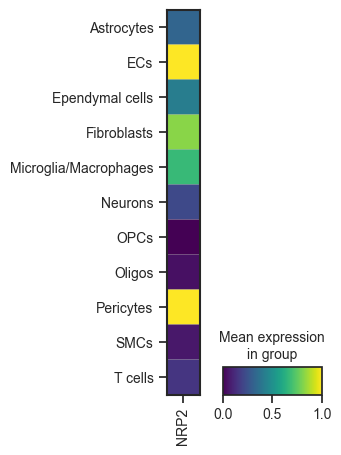

In [112]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

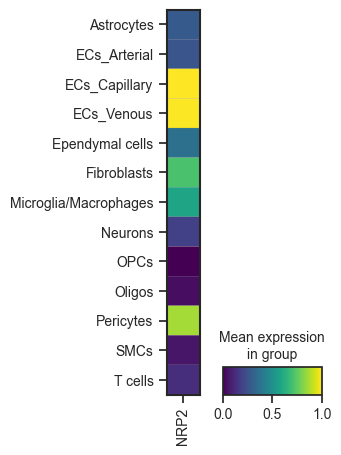

In [113]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


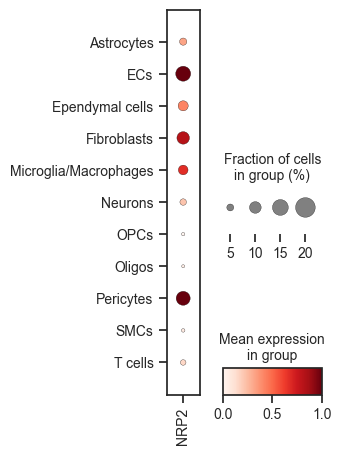

In [114]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


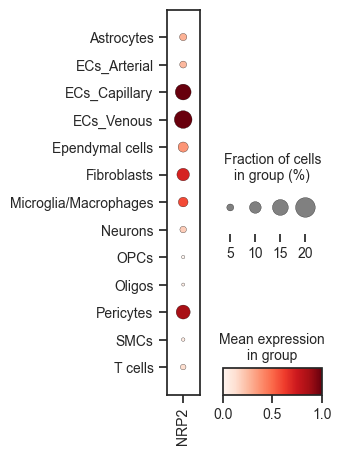

In [115]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [116]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.321317
ECs                           0.999818
Ependymal cells               0.421025
Fibroblasts                   0.822594
Microglia/Macrophages         0.674648
Neurons                       0.220470
OPCs                          0.000000
Oligos                        0.040011
Pericytes                     1.000000
SMCs                          0.063252
T cells                       0.152972

In [117]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.053002
ECs                             0.138900
Ependymal cells                 0.082486
Fibroblasts                     0.109744
Microglia/Macrophages           0.077933
Neurons                         0.046088
OPCs                            0.019218
Oligos                          0.016768
Pericytes                       0.127214
SMCs                            0.020347
T cells                         0.037433

In [118]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells  gene    source  \
clusters                                                                    
Astrocytes                    0.321317           0.053002  NRP2  Yang2022   
ECs                           0.999818           0.138900  NRP2  Yang2022   
Ependymal cells               0.421025           0.082486  NRP2  Yang2022   
Fibroblasts                   0.822594           0.109744  NRP2  Yang2022   
Microglia/Macrophages         0.674648           0.077933  NRP2  Yang2022   
Neurons                       0.220470           0.046088  NRP2  Yang2022   
OPCs                          0.000000           0.019218  NRP2  Yang2022   
Oligos                        0.040011           0.016768  NRP2  Yang2022   
Pericytes                     1.000000           0.127214  NRP2  Yang2022   
SMCs                          0.063252           0.020347  NRP2  Yang2022   
T cells                       0.152972           0.037433  NRP2  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [119]:
# export
name='Yang2022'

In [120]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [121]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [122]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [123]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells  gene    source  \
clusters2                                                                   
Astrocytes                    0.278139           0.053002  NRP2  Yang2022   
ECs_Arterial                  0.257969           0.049933  NRP2  Yang2022   
ECs_Capillary                 1.000000           0.149959  NRP2  Yang2022   
ECs_Venous                    0.995491           0.174114  NRP2  Yang2022   
Ependymal cells               0.364448           0.082486  NRP2  Yang2022   
Fibroblasts                   0.712056           0.109744  NRP2  Yang2022   
Microglia/Macrophages         0.583991           0.077933  NRP2  Yang2022   
Neurons                       0.190844           0.046088  NRP2  Yang2022   
OPCs                          0.000000           0.019218  NRP2  Yang2022   
Oligos                        0.034634           0.016768  NRP2  Yang2022   
Pericytes                     0.865623           0.127214  NRP2  Yang2022   
SMCs                          0.054752           0.020347  NRP2  Yang2022   
T cells                       0.132416           0.037433  NRP2  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [124]:
# export
name='Yang2022'

In [125]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## EFNB2

In [126]:
gene="EFNB2"

### Plot

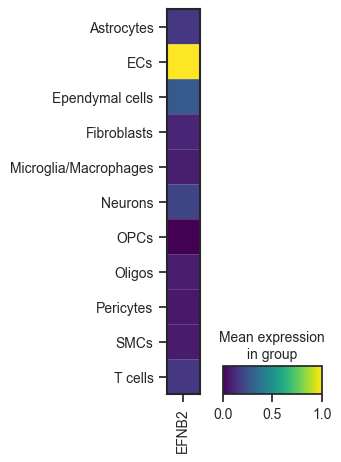

In [127]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

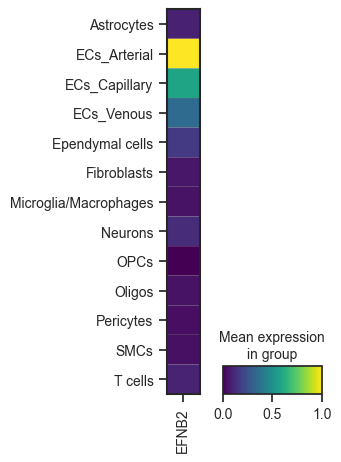

In [128]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


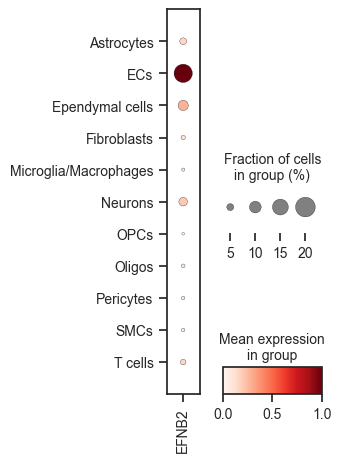

In [129]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


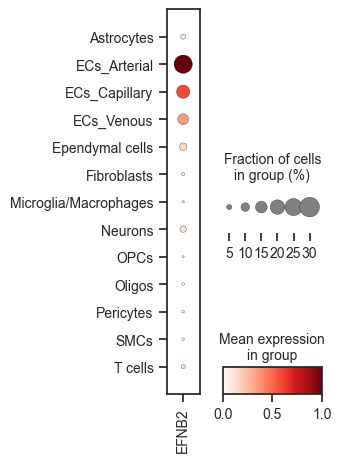

In [130]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [131]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.157157
ECs                           1.000000
Ependymal cells               0.280145
Fibroblasts                   0.104511
Microglia/Macrophages         0.085753
Neurons                       0.206713
OPCs                          0.000000
Oligos                        0.081853
Pericytes                     0.064612
SMCs                          0.071150
T cells                       0.158853

In [132]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.048879
ECs                             0.181811
Ependymal cells                 0.083616
Fibroblasts                     0.026575
Microglia/Macrophages           0.017513
Neurons                         0.066452
OPCs                            0.013917
Oligos                          0.021576
Pericytes                       0.019532
SMCs                            0.019919
T cells                         0.037433

In [133]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells   gene    source  \
clusters                                                                     
Astrocytes                    0.157157           0.048879  EFNB2  Yang2022   
ECs                           1.000000           0.181811  EFNB2  Yang2022   
Ependymal cells               0.280145           0.083616  EFNB2  Yang2022   
Fibroblasts                   0.104511           0.026575  EFNB2  Yang2022   
Microglia/Macrophages         0.085753           0.017513  EFNB2  Yang2022   
Neurons                       0.206713           0.066452  EFNB2  Yang2022   
OPCs                          0.000000           0.013917  EFNB2  Yang2022   
Oligos                        0.081853           0.021576  EFNB2  Yang2022   
Pericytes                     0.064612           0.019532  EFNB2  Yang2022   
SMCs                          0.071150           0.019919  EFNB2  Yang2022   
T cells                       0.158853           0.037433  EFNB2  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [134]:
# export
name='Yang2022'

In [135]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [136]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [137]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [138]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells   gene    source  \
clusters2                                                                    
Astrocytes                    0.092874           0.048879  EFNB2  Yang2022   
ECs_Arterial                  1.000000           0.273295  EFNB2  Yang2022   
ECs_Capillary                 0.583681           0.176312  EFNB2  Yang2022   
ECs_Venous                    0.347565           0.134613  EFNB2  Yang2022   
Ependymal cells               0.165556           0.083616  EFNB2  Yang2022   
Fibroblasts                   0.061762           0.026575  EFNB2  Yang2022   
Microglia/Macrophages         0.050677           0.017513  EFNB2  Yang2022   
Neurons                       0.122160           0.066452  EFNB2  Yang2022   
OPCs                          0.000000           0.013917  EFNB2  Yang2022   
Oligos                        0.048372           0.021576  EFNB2  Yang2022   
Pericytes                     0.038183           0.019532  EFNB2  Yang2022   
SMCs                          0.042047           0.019919  EFNB2  Yang2022   
T cells                       0.093876           0.037433  EFNB2  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [139]:
# export
name='Yang2022'

In [140]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## ITGB1

In [141]:
gene="ITGB1"

### Plot

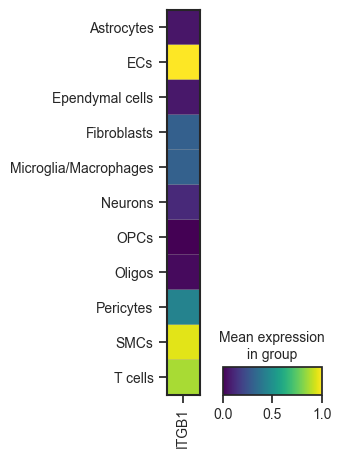

In [142]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

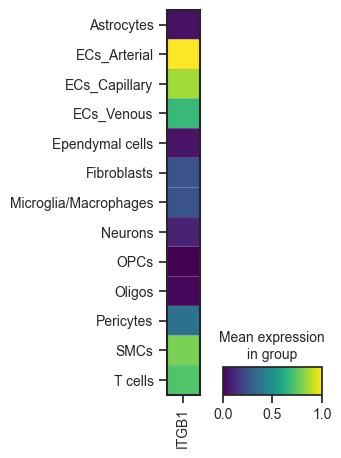

In [143]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


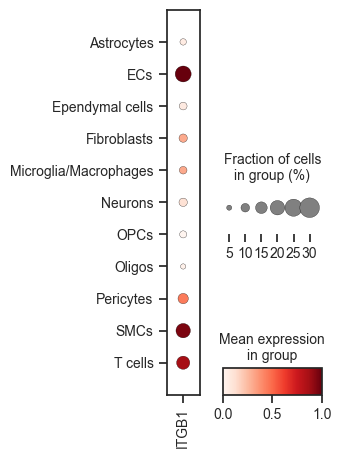

In [144]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


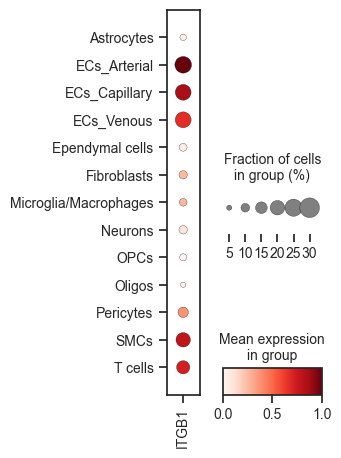

In [145]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [146]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.055473
ECs                           1.000000
Ependymal cells               0.063419
Fibroblasts                   0.301713
Microglia/Macrophages         0.307944
Neurons                       0.113920
OPCs                          0.000000
Oligos                        0.024616
Pericytes                     0.447354
SMCs                          0.953485
T cells                       0.870547

In [147]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.067988
ECs                             0.227444
Ependymal cells                 0.087006
Fibroblasts                     0.095965
Microglia/Macrophages           0.084939
Neurons                         0.096463
OPCs                            0.077535
Oligos                          0.052064
Pericytes                       0.128068
SMCs                            0.198972
T cells                         0.176471

In [148]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells   gene    source  \
clusters                                                                     
Astrocytes                    0.055473           0.067988  ITGB1  Yang2022   
ECs                           1.000000           0.227444  ITGB1  Yang2022   
Ependymal cells               0.063419           0.087006  ITGB1  Yang2022   
Fibroblasts                   0.301713           0.095965  ITGB1  Yang2022   
Microglia/Macrophages         0.307944           0.084939  ITGB1  Yang2022   
Neurons                       0.113920           0.096463  ITGB1  Yang2022   
OPCs                          0.000000           0.077535  ITGB1  Yang2022   
Oligos                        0.024616           0.052064  ITGB1  Yang2022   
Pericytes                     0.447354           0.128068  ITGB1  Yang2022   
SMCs                          0.953485           0.198972  ITGB1  Yang2022   
T cells                       0.870547           0.176471  ITGB1  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [149]:
# export
name='Yang2022'

In [150]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [151]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [152]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [153]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells   gene    source  \
clusters2                                                                    
Astrocytes                    0.046184           0.067988  ITGB1  Yang2022   
ECs_Arterial                  1.000000           0.240749  ITGB1  Yang2022   
ECs_Capillary                 0.860643           0.223928  ITGB1  Yang2022   
ECs_Venous                    0.674802           0.225662  ITGB1  Yang2022   
Ependymal cells               0.052801           0.087006  ITGB1  Yang2022   
Fibroblasts                   0.251194           0.095965  ITGB1  Yang2022   
Microglia/Macrophages         0.256382           0.084939  ITGB1  Yang2022   
Neurons                       0.094845           0.096463  ITGB1  Yang2022   
OPCs                          0.000000           0.077535  ITGB1  Yang2022   
Oligos                        0.020494           0.052064  ITGB1  Yang2022   
Pericytes                     0.372449           0.128068  ITGB1  Yang2022   
SMCs                          0.793834           0.198972  ITGB1  Yang2022   
T cells                       0.724783           0.176471  ITGB1  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [154]:
# export
name='Yang2022'

In [155]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## ANGPT2

In [156]:
gene="ANGPT2"

### Plot

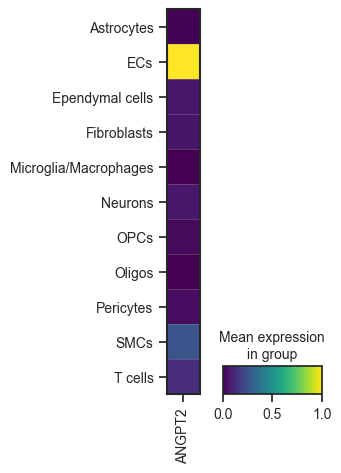

In [157]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

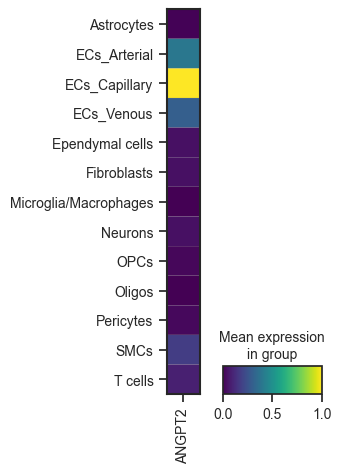

In [158]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


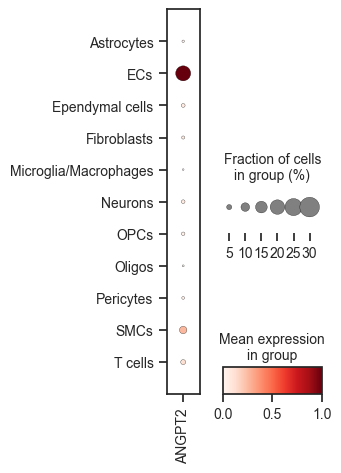

In [159]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


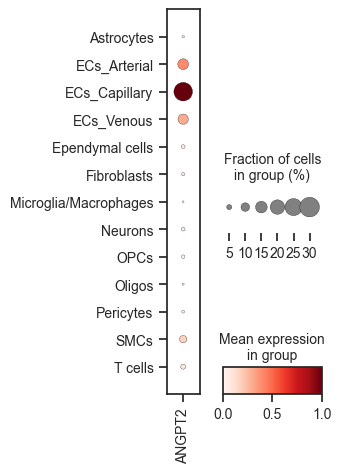

In [160]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [161]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.006175
ECs                           1.000000
Ependymal cells               0.061098
Fibroblasts                   0.058214
Microglia/Macrophages         0.001085
Neurons                       0.061945
OPCs                          0.026274
Oligos                        0.000000
Pericytes                     0.031591
SMCs                          0.259452
T cells                       0.128510

In [162]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.018908
ECs                             0.209751
Ependymal cells                 0.033898
Fibroblasts                     0.026083
Microglia/Macrophages           0.011384
Neurons                         0.032154
OPCs                            0.030484
Oligos                          0.013720
Pericytes                       0.022322
SMCs                            0.081602
T cells                         0.048128

In [163]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells    gene    source  \
clusters                                                                      
Astrocytes                    0.006175           0.018908  ANGPT2  Yang2022   
ECs                           1.000000           0.209751  ANGPT2  Yang2022   
Ependymal cells               0.061098           0.033898  ANGPT2  Yang2022   
Fibroblasts                   0.058214           0.026083  ANGPT2  Yang2022   
Microglia/Macrophages         0.001085           0.011384  ANGPT2  Yang2022   
Neurons                       0.061945           0.032154  ANGPT2  Yang2022   
OPCs                          0.026274           0.030484  ANGPT2  Yang2022   
Oligos                        0.000000           0.013720  ANGPT2  Yang2022   
Pericytes                     0.031591           0.022322  ANGPT2  Yang2022   
SMCs                          0.259452           0.081602  ANGPT2  Yang2022   
T cells                       0.128510           0.048128  ANGPT2  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [164]:
# export
name='Yang2022'

In [165]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [166]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [167]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [168]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells    gene    source  \
clusters2                                                                     
Astrocytes                    0.004266           0.018908  ANGPT2  Yang2022   
ECs_Arterial                  0.396880           0.134418  ANGPT2  Yang2022   
ECs_Capillary                 1.000000           0.278880  ANGPT2  Yang2022   
ECs_Venous                    0.297364           0.127749  ANGPT2  Yang2022   
Ependymal cells               0.042213           0.033898  ANGPT2  Yang2022   
Fibroblasts                   0.040220           0.026083  ANGPT2  Yang2022   
Microglia/Macrophages         0.000749           0.011384  ANGPT2  Yang2022   
Neurons                       0.042798           0.032154  ANGPT2  Yang2022   
OPCs                          0.018153           0.030484  ANGPT2  Yang2022   
Oligos                        0.000000           0.013720  ANGPT2  Yang2022   
Pericytes                     0.021827           0.022322  ANGPT2  Yang2022   
SMCs                          0.179258           0.081602  ANGPT2  Yang2022   
T cells                       0.088788           0.048128  ANGPT2  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [169]:
# export
name='Yang2022'

In [170]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

## CDH5

In [171]:
gene="CDH5"

### Plot

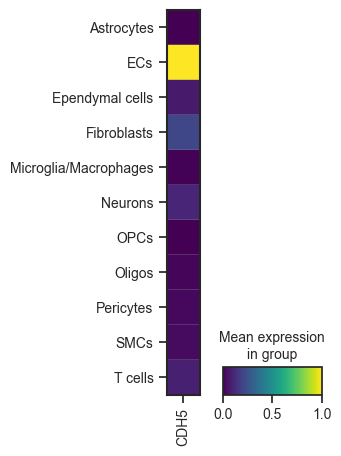

In [172]:
sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

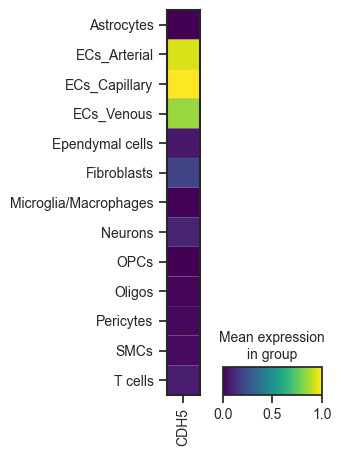

In [173]:
sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


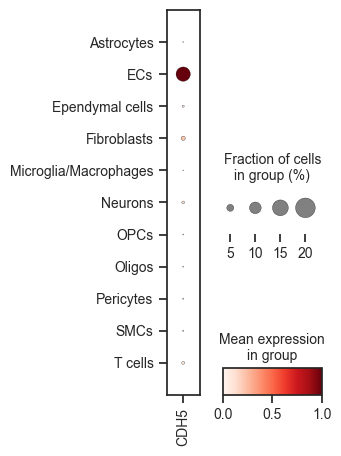

In [174]:
sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

D:\Programme\Anaconda\envs\scanpy\Lib\site-packages\scanpy\plotting\_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


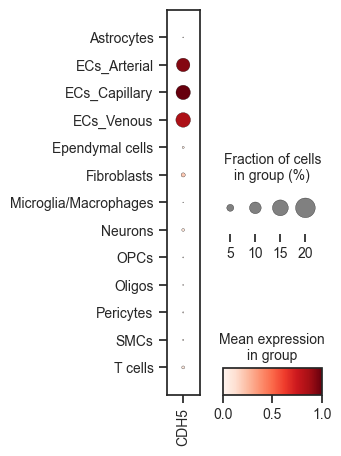

In [175]:
sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", layer="normalized")

### Excl zonation

In [176]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']
ex

mean_expression
clusters                              
Astrocytes                    0.001081
ECs                           1.000000
Ependymal cells               0.066565
Fibroblasts                   0.212181
Microglia/Macrophages         0.006050
Neurons                       0.104501
OPCs                          0.000000
Oligos                        0.015108
Pericytes                     0.020704
SMCs                          0.030731
T cells                       0.086698

In [177]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']
fc

fraction_of_cells
clusters                                
Astrocytes                      0.003319
ECs                             0.130814
Ependymal cells                 0.010169
Fibroblasts                     0.025098
Microglia/Macrophages           0.002627
Neurons                         0.015005
OPCs                            0.003976
Oligos                          0.004221
Pericytes                       0.005011
SMCs                            0.005354
T cells                         0.016043

In [178]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells  gene    source  \
clusters                                                                    
Astrocytes                    0.001081           0.003319  CDH5  Yang2022   
ECs                           1.000000           0.130814  CDH5  Yang2022   
Ependymal cells               0.066565           0.010169  CDH5  Yang2022   
Fibroblasts                   0.212181           0.025098  CDH5  Yang2022   
Microglia/Macrophages         0.006050           0.002627  CDH5  Yang2022   
Neurons                       0.104501           0.015005  CDH5  Yang2022   
OPCs                          0.000000           0.003976  CDH5  Yang2022   
Oligos                        0.015108           0.004221  CDH5  Yang2022   
Pericytes                     0.020704           0.005011  CDH5  Yang2022   
SMCs                          0.030731           0.005354  CDH5  Yang2022   
T cells                       0.086698           0.016043  CDH5  Yang2022   

                      organism  cell_number  
clusters                                     
Astrocytes               Human         9943  
ECs                      Human        24982  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [179]:
# export
name='Yang2022'

In [180]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_normalized.csv',sep=';')

### Incl zonation

In [181]:
# mean expression per group (normalized and scaled)
ex = sc.pl.matrixplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,5), standard_scale="var", return_fig=True, layer="normalized").values_df
ex.columns = ['mean_expression']

In [182]:
# dotplot dot size = fraction of cells in group expressing Foxf2
fc = sc.pl.dotplot(adata, [gene], groupby='clusters2', swap_axes=False, figsize=(2,7), standard_scale="var",return_fig=True, layer="normalized").dot_size_df
fc.columns = ['fraction_of_cells']

In [183]:
othergene = pd.concat([ex, fc], axis=1)
othergene['gene'] = gene
othergene['source'] = "Yang2022"
othergene['organism'] = "Human"
othergene['cell_number'] = pd.DataFrame(adata.obs["clusters2"].value_counts()).reindex(othergene.index)
othergene

mean_expression  fraction_of_cells  gene    source  \
clusters2                                                                   
Astrocytes                    0.001021           0.003319  CDH5  Yang2022   
ECs_Arterial                  0.938314           0.120820  CDH5  Yang2022   
ECs_Capillary                 1.000000           0.132066  CDH5  Yang2022   
ECs_Venous                    0.844550           0.134753  CDH5  Yang2022   
Ependymal cells               0.062871           0.010169  CDH5  Yang2022   
Fibroblasts                   0.200405           0.025098  CDH5  Yang2022   
Microglia/Macrophages         0.005714           0.002627  CDH5  Yang2022   
Neurons                       0.098701           0.015005  CDH5  Yang2022   
OPCs                          0.000000           0.003976  CDH5  Yang2022   
Oligos                        0.014270           0.004221  CDH5  Yang2022   
Pericytes                     0.019555           0.005011  CDH5  Yang2022   
SMCs                          0.029025           0.005354  CDH5  Yang2022   
T cells                       0.081886           0.016043  CDH5  Yang2022   

                      organism  cell_number  
clusters2                                    
Astrocytes               Human         9943  
ECs_Arterial             Human         4486  
ECs_Capillary            Human        13357  
ECs_Venous               Human         7139  
Ependymal cells          Human          885  
Fibroblasts              Human         2032  
Microglia/Macrophages    Human         1142  
Neurons                  Human          933  
OPCs                     Human         1509  
Oligos                   Human         8528  
Pericytes                Human        17561  
SMCs                     Human         4669  
T cells                  Human          187

In [184]:
# export
name='Yang2022'

In [185]:
# Win
othergene.to_csv(main_dir+'\\P06_Foxf2_per_celltype\\Other_genes_summarized\\incl_zonation\\'+ date.today().strftime("%Y%m%d")+'_'+gene+'_'+name+'_incl_zonation_normalized.csv',sep=';')

# Correlate gene expression (Foxf2 and Foxo1)

Using MAGIC denoising

In [60]:
import magic
import scprep

In [61]:
#sc.pp.scale(adata)

## ECs

In [62]:
gg = ["FOXF2","FOXO1","NOS3"]

In [63]:
adata_EC = adata[adata.obs.clusters == "ECs"]

In [64]:
adata_EC

View of AnnData object with n_obs × n_vars = 24982 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type', 'clusters2', 'clusters'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_Type_colors', 'clusters_colors', 'clusters2_colors', 'Region_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [65]:
adata_EC.layers

LayersView with keys: counts, normalized

In [66]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [67]:
cutoff_var = None

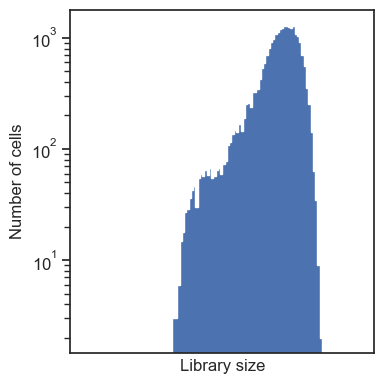

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [68]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [69]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [70]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [71]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [72]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 24982 cells and 23537 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 9.22 seconds.
    Calculating KNN search...
    Calculated KNN search in 111.61 seconds.
    Calculating affinities...
    Calculated affinities in 111.54 seconds.
  Calculated graph and diffusion operator in 232.47 seconds.
  Calculating imputation...
  Calculated imputation in 0.02 seconds.
Calculated MAGIC in 232.70 seconds.
CPU times: total: 3min 53s
Wall time: 3min 52s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [73]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

-0.15517466438846958

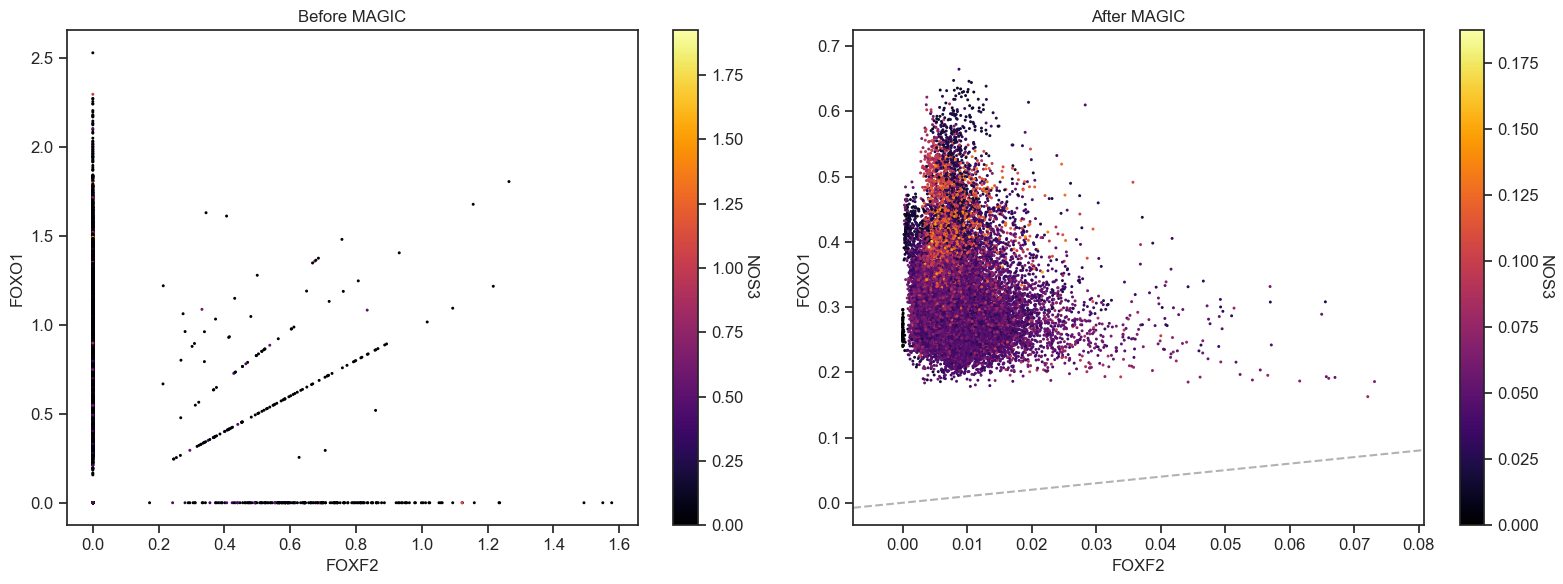

In [76]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X.todense(), y=adata_EC[:,'FOXO1'].X.todense(), c=adata_EC[:,'NOS3'].X.todense(), ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## PCs

In [77]:
gg = ["FOXF2","FOXO1","NOS3"]

In [78]:
adata_EC = adata[adata.obs.clusters == "Pericytes"]

In [79]:
adata_EC

View of AnnData object with n_obs × n_vars = 17561 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type', 'clusters2', 'clusters'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_Type_colors', 'clusters_colors', 'clusters2_colors', 'Region_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [80]:
adata_EC.layers

LayersView with keys: counts, normalized

In [81]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [82]:
cutoff_var = None

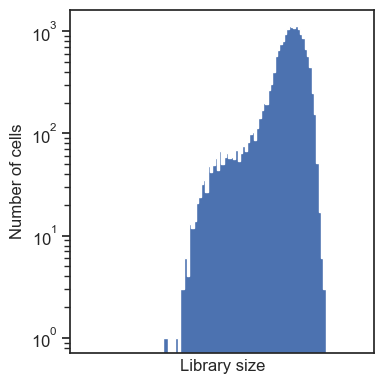

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [83]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [84]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [85]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [86]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [87]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 17561 cells and 23537 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 6.41 seconds.
    Calculating KNN search...
    Calculated KNN search in 52.27 seconds.
    Calculating affinities...
    Calculated affinities in 54.16 seconds.
  Calculated graph and diffusion operator in 112.94 seconds.
  Calculating imputation...
Calculated MAGIC in 113.09 seconds.
CPU times: total: 1min 53s
Wall time: 1min 53s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [88]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

-0.10976434784787703

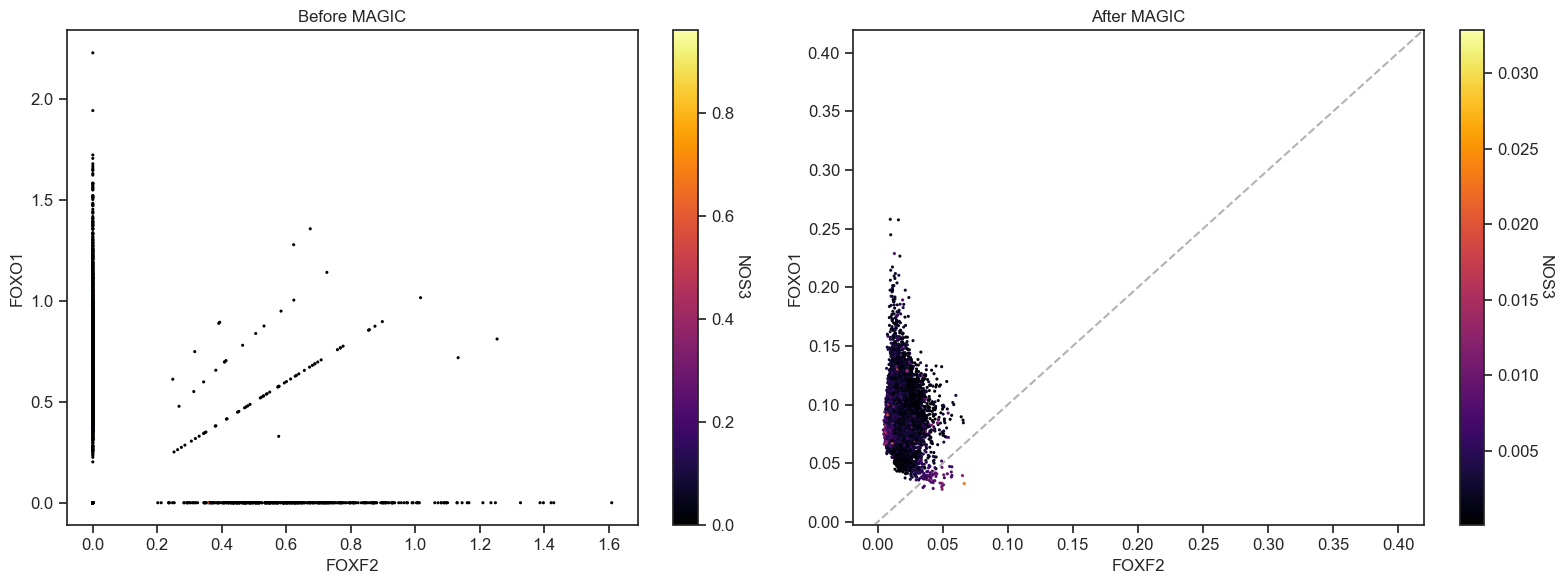

In [89]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X.todense(), y=adata_EC[:,'FOXO1'].X.todense(), c=adata_EC[:,'NOS3'].X.todense(), ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0.4,0.4), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## All cell types

In [90]:
gg = ["FOXF2","FOXO1","NOS3"]

In [91]:
adata

AnnData object with n_obs × n_vars = 72371 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type', 'clusters2', 'clusters'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_Type_colors', 'clusters_colors', 'clusters2_colors', 'Region_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [92]:
adata.layers

Layers with keys: counts, normalized

In [93]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata.X
matrix.columns = adata.var.index.tolist()

In [94]:
cutoff_var = None

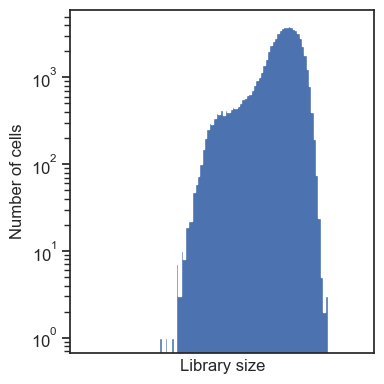

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [95]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [96]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [97]:
adata.layers

Layers with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [98]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [99]:
%%time
emt_magic = magic_op.fit_transform(adata, genes=gg)

Calculating MAGIC...
  Running MAGIC on 72371 cells and 23537 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 26.57 seconds.
    Calculating KNN search...
    Calculated KNN search in 737.60 seconds.
    Calculating affinities...
    Calculated affinities in 734.99 seconds.
  Calculated graph and diffusion operator in 1499.31 seconds.
  Calculating imputation...
  Calculated imputation in 0.05 seconds.
Calculated MAGIC in 1499.59 seconds.
CPU times: total: 24min 51s
Wall time: 24min 59s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [100]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

-0.3124673872444054

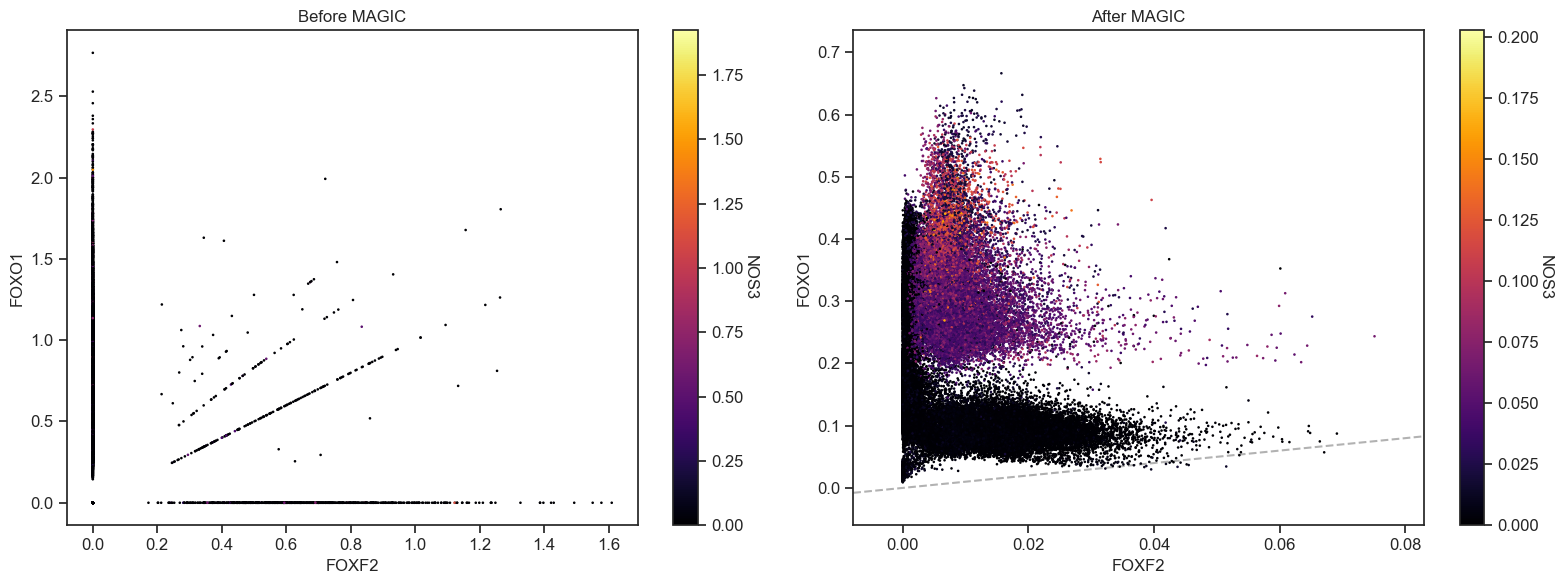

In [102]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata[:,'FOXF2'].X.todense(), y=adata[:,'FOXO1'].X.todense(), c=adata[:,'NOS3'].X.todense(), ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## capECs

In [103]:
gg = ["FOXF2","FOXO1","NOS3"]

In [104]:
adata_EC = adata[adata.obs.clusters2 == "ECs_Capillary"]

In [105]:
adata_EC

View of AnnData object with n_obs × n_vars = 13357 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type', 'clusters2', 'clusters'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_Type_colors', 'clusters_colors', 'clusters2_colors', 'Region_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [106]:
adata_EC.layers

LayersView with keys: counts, normalized

In [107]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [108]:
cutoff_var = None

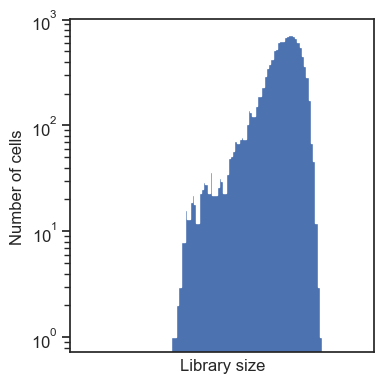

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [109]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [110]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [111]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [112]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [113]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 13357 cells and 23537 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 5.03 seconds.
    Calculating KNN search...
    Calculated KNN search in 27.94 seconds.
    Calculating affinities...
    Calculated affinities in 28.73 seconds.
  Calculated graph and diffusion operator in 61.76 seconds.
  Calculating imputation...
Calculated MAGIC in 61.91 seconds.
CPU times: total: 1min 2s
Wall time: 1min 1s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [118]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

-0.15148391797878671

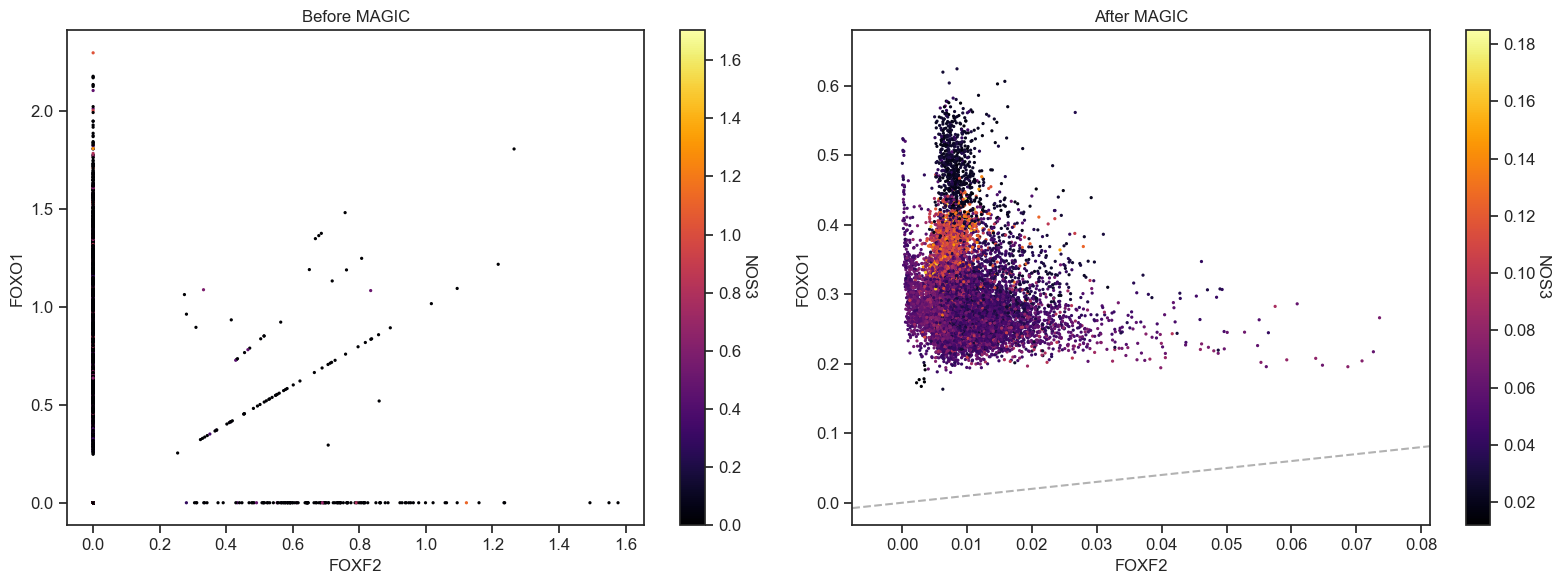

In [119]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X.todense(), y=adata_EC[:,'FOXO1'].X.todense(), c=adata_EC[:,'NOS3'].X.todense(), ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## aECs

In [120]:
gg = ["FOXF2","FOXO1","NOS3"]

In [121]:
adata_EC = adata[adata.obs.clusters2 == "ECs_Arterial"]

In [122]:
adata_EC

View of AnnData object with n_obs × n_vars = 4486 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type', 'clusters2', 'clusters'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_Type_colors', 'clusters_colors', 'clusters2_colors', 'Region_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [123]:
adata_EC.layers

LayersView with keys: counts, normalized

In [124]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [125]:
cutoff_var = None

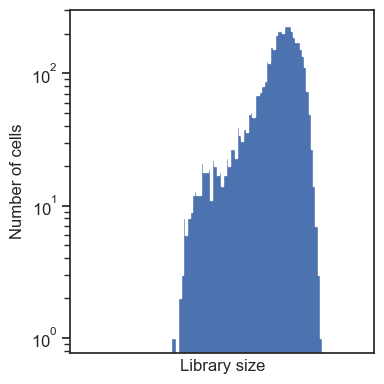

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [126]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [127]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [128]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [129]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [130]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 4486 cells and 23537 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 1.98 seconds.
    Calculating KNN search...
    Calculated KNN search in 2.36 seconds.
    Calculating affinities...
    Calculated affinities in 2.43 seconds.
  Calculated graph and diffusion operator in 6.79 seconds.
  Calculating imputation...
Calculated MAGIC in 6.88 seconds.
CPU times: total: 7.48 s
Wall time: 6.88 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [131]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

0.027441947623382503

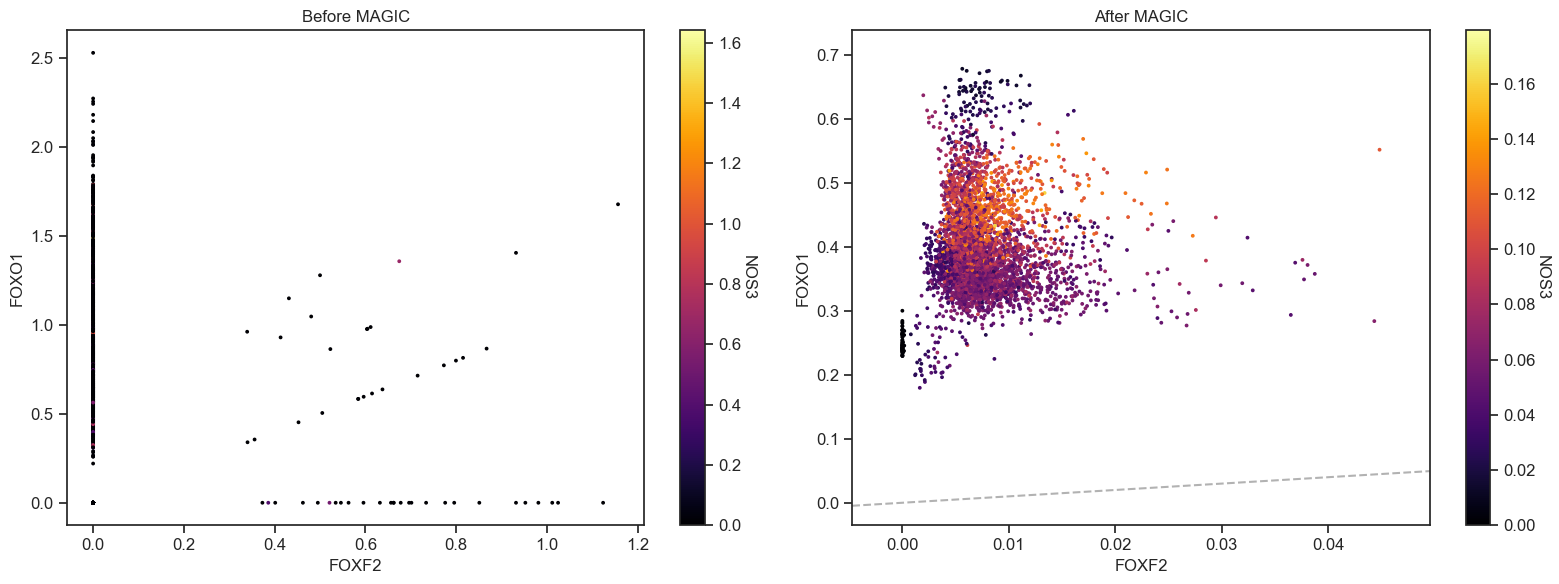

In [132]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X.todense(), y=adata_EC[:,'FOXO1'].X.todense(), c=adata_EC[:,'NOS3'].X.todense(), ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

## vECs

In [133]:
gg = ["FOXF2","FOXO1","NOS3"]

In [134]:
adata_EC = adata[adata.obs.clusters2 == "ECs_Venous"]

In [135]:
adata_EC

View of AnnData object with n_obs × n_vars = 7139 × 23537
    obs: 'Cell', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Treat', 'Sample', 'Region', 'nCount_SCT', 'nFeature_SCT', 'integrated_snn_res.0.3', 'integrated_snn_res.0.35', 'Gender', 'Age', 'Batch', 'Sample_Region', 'Region_Number', 'Seurat_n', 'Seurat_Clusters', 'APOE4', 'APOE34', 'APOE_Number', 'Cell_Type', 'clusters2', 'clusters'
    var: 0, 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Cell_Type_colors', 'clusters_colors', 'clusters2_colors', 'Region_colors', 'log1p', 'hvg'
    obsm: 'X_umap'
    layers: 'counts', 'normalized'

In [136]:
adata_EC.layers

LayersView with keys: counts, normalized

In [137]:
#matrix = pd.DataFrame(adata_EC.X) # not compatible with sparse 
matrix = adata_EC.X
matrix.columns = adata_EC.var.index.tolist()

In [138]:
cutoff_var = None

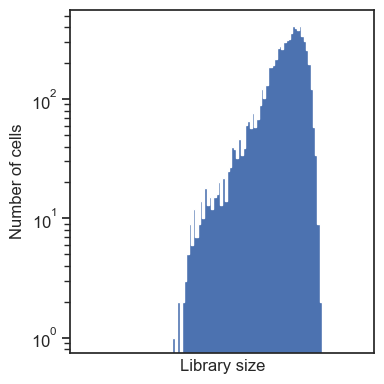

<Axes: xlabel='Library size', ylabel='Number of cells'>

In [139]:
scprep.plot.plot_library_size(matrix, cutoff=cutoff_var)

In [140]:
# filter lowly expressed genes and cells with a small library size
#matrix = scprep.filter.filter_library_size(matrix, cutoff=cutoff_var)
#matrix.head()

Note: Skipped normalization as data is already log-normalized

In [141]:
adata_EC.layers

LayersView with keys: counts, normalized

### Creating the MAGIC operator
If you don't specify parameters, MAGIC creates an operator with the following default values: knn=5, knn_max = 3 * knn, decay=1, t=3.

In [142]:
magic_op = magic.MAGIC()

### Running MAGIC with gene selection
The magic_op.fit_transform function takes the normalized data and an array of selected genes as its arguments. If no genes are provided, MAGIC will return a matrix of all genes. The same can be achieved by substituting the array of gene names with genes='all_genes'.

In [143]:
%%time
emt_magic = magic_op.fit_transform(adata_EC, genes=gg)

Calculating MAGIC...
  Running MAGIC on 7139 cells and 23537 genes.
  Calculating graph and diffusion operator...
    Calculating PCA...


C:\Users\sfrerich\AppData\Roaming\Python\Python311\site-packages\magic\magic.py:425: UserWarning: Input matrix contains unexpressed genes. Please remove them prior to running MAGIC.
  warnings.warn(


    Calculated PCA in 3.62 seconds.
    Calculating KNN search...
    Calculated KNN search in 6.30 seconds.
    Calculating affinities...
    Calculated affinities in 6.39 seconds.
  Calculated graph and diffusion operator in 16.36 seconds.
  Calculating imputation...
  Calculated imputation in 0.01 seconds.
Calculated MAGIC in 16.47 seconds.
CPU times: total: 17.6 s
Wall time: 16.5 s


### Visualizing gene-gene relationships

We can see gene-gene relationships much more clearly after applying MAGIC. Note that the change in absolute values of gene expression is not meaningful - the relative difference is all that matters.

In [144]:
np.corrcoef(emt_magic[:,['FOXF2','FOXO1']].X, rowvar = False)[0][1]

0.09890455251113217

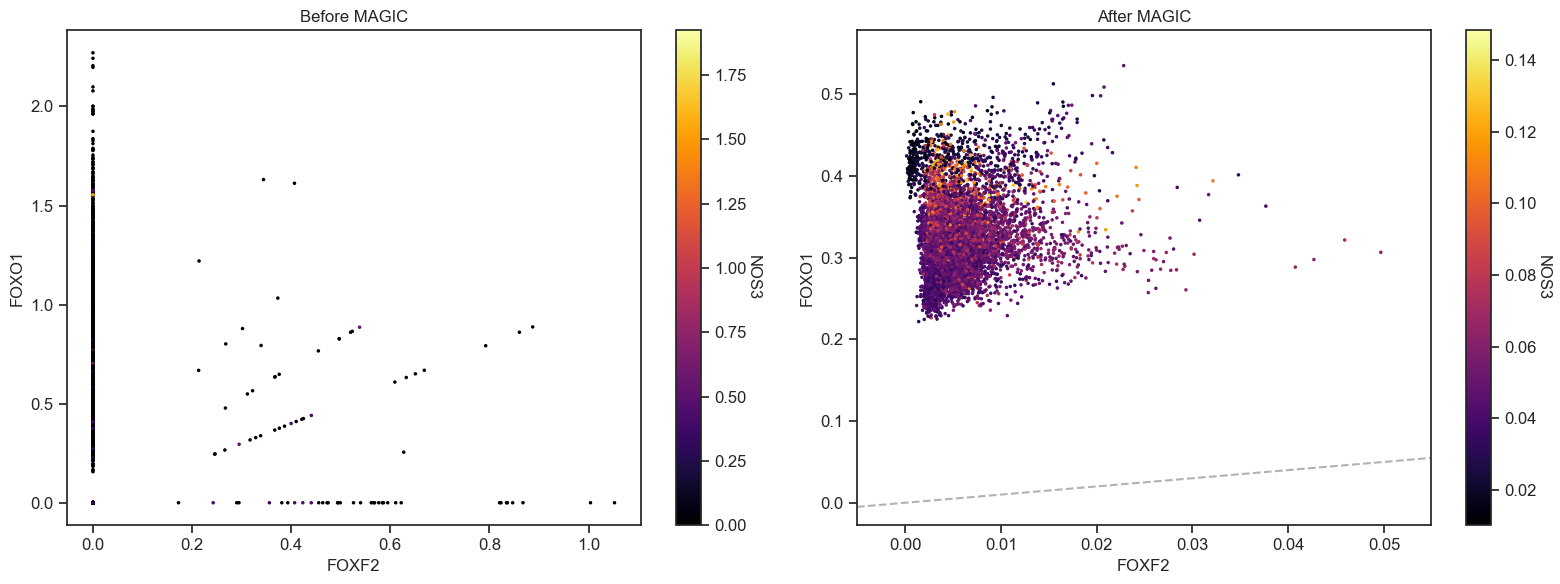

In [145]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 6))
scprep.plot.scatter(x=adata_EC[:,'FOXF2'].X.todense(), y=adata_EC[:,'FOXO1'].X.todense(), c=adata_EC[:,'NOS3'].X.todense(), ax = ax1,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='Before MAGIC')
scprep.plot.scatter(x=emt_magic[:,'FOXF2'].X, y=emt_magic[:,'FOXO1'].X, c=emt_magic[:,'NOS3'].X, ax=ax2,
                    xlabel='FOXF2', ylabel='FOXO1', legend_title="NOS3", title='After MAGIC')
plt.axline((0,0), slope=1, color="black", alpha=0.3, linestyle="--")
plt.tight_layout()
plt.show()

# Session Info

In [146]:
sc.logging.print_versions()

-----
anndata     0.9.2
scanpy      1.9.4
-----
PIL                 10.0.0
anyio               NA
asttokens           NA
attr                22.1.0
babel               2.11.0
backcall            0.2.0
brotli              NA
certifi             2023.07.22
cffi                1.15.1
charset_normalizer  2.0.4
colorama            0.4.6
comm                0.1.2
cycler              0.10.0
cython_runtime      NA
dateutil            2.8.2
debugpy             1.6.7
decorator           5.1.1
defusedxml          0.7.1
deprecated          1.2.14
entrypoints         0.4
executing           0.8.3
fastjsonschema      NA
future              0.18.3
graphtools          1.5.3
h5py                3.9.0
idna                3.4
igraph              0.10.4
ipykernel           6.25.0
ipython_genutils    0.2.0
ipywidgets          8.0.4
jedi                0.18.1
jinja2              3.0.3
joblib              1.3.2
json5               NA
jsonschema          4.17.3
jupyter_server      1.23.4
jupyterlab_server   2